# Wavelength dependence of total PI, Qphi and unresolved components



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp
import functions as f
import scipy.ndimage as ndimage
import matplotlib.lines as mlines
import matplotlib.ticker as ticker

def LoadImage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data

            
    return fit

def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout

In [5]:
def load_tel_corr(dirdat,camera,process):
    dir = dirdat
    files = os.listdir(dir)
    qfile = 'qcorr_'+str(process)+'_'+str(camera)+'.fits'
    ufile = 'ucorr_'+str(process)+'_'+str(camera)+'.fits'
    qphifile = 'qphi_'+str(process)+'_'+str(camera)+'.fits'
    uphifile = 'uphi_'+str(process)+'_'+str(camera)+'.fits'
    
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            q = hdulq[0].data
        if fnmatch.fnmatch(file, ufile):
            hdulq = fits.open(dir + file)
            u = hdulq[0].data
        #if fnmatch.fnmatch(file, qphifile):
        #    hdulq = fits.open(dir + file)
        #    q_phi = hdulq[0].data
        #if fnmatch.fnmatch(file, uphifile):
        #    hdulq = fits.open(dir + file)
        #    u_phi = hdulq[0].data    
            
            
    n=q.shape[0]
     #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)
    phi = np.arctan(Yr/Xr)
    q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)
    q_phi = (q_phi > 0)*q_phi +  (q_phi <=0 )*1e-16
    u_phi=q*np.sin(2*phi)+u*np.cos(2*phi)    
    
    return q,u,q_phi,u_phi

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   

def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def Loadimagespsf_AR(star):
    dir = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/classic_reduction/'+star+'/'
 
    psfile =  '*REDUCED_I.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            PSFv = hdulPSF[0].data[0]
            PSFi = hdulPSF[0].data[1]
            
    return PSFv,PSFi

def load_I(dirdat,process):
    dir = dirdat
    qfile = str(process)+'*'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            #q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            #u = hdulq[0].data[3]
            n=iq.shape[0]
            i=(iq+iu)/2
            
    return iq,iu,i

def plot_with_unres_Aolp(image,aolp,dolp,lim,ps):

    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = image.shape[0]
    d = n * ps / 2
        #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)


    im1=i_plot.imshow(np.arcsinh(image),extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical',shrink=0.8)
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    #plt.tight_layout(pad=0.1)     

    # polarization angle
    psi=np.deg2rad(aolp*1.)


    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = dolp*np.cos(psi+np.pi/2) # X-vector 
    pixY = dolp*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(0, 0, pixX, pixY,scale=0.08, **quiveropts)

def calculate_unresolved(correction_radius, q, u,i,ps,R,normlim):
    # Calculates degree and angle of unresolved polarisation
    #resulting values are in fraction (not %) for dolp, and in degrees for aolp

    mask=(R<=correction_radius)

    normalisation=np.sum(i[R<=1500/ps])
    q_over_i=np.divide(q,i,where=i!=0)   
    cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
    u_over_i=np.divide(u,i,where=i!=0)    
    cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
    aolp_unres=np.rad2deg(0.5*np.arctan2(cu, cq))
    #print(aolp_unres)
    if aolp_unres<0 : 
        aolp_unres=aolp_unres+180
    dolp_unres=np.sum(np.sqrt(cu*i*cu*i+ cq*i*cq*i)*(R<=normlim))/normalisation
    
    q_corr=q-cq*i
    u_corr=u-cu*i
    return dolp_unres, aolp_unres,q_corr,u_corr
      
def maskcrit(aolp,R):
    phi = (aolp) #ndimage.gaussian_filter(aolp, sigma=(2, 2), order=1)#
    
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>np.pi/2:
                #print(phi[ix,iy])
                phi[ix,iy]=phi[ix,iy]-np.pi/2
            
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]<-np.pi/2:
                
                phi[ix,iy]=phi[ix,iy]+np.pi/2      
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmean(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        
def plot_AoLP(ps,Q,U,R,I,Q_PHI,title,save,plot,noise,lim):
    
    n = Q_PHI.shape[0]
    Q=Q[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    U=U[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    R=R[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    I=I[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    Q_PHI=Q_PHI[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    n = Q_PHI.shape[0]
    d = n * ps / 2

    im1=ax.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))
    #plt.xlim(-lim * ps, lim * ps)
    #plt.ylim(-lim * ps, lim * ps)
    fig.colorbar(im1, orientation='vertical',shrink=0.75)

    plt.xlabel('mas',fontsize=14)
    plt.ylabel("mas",fontsize=14)
     
    ax.tick_params(axis='both',labelsize=14)
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = ax.get_xlim()
    yy0, yy1 = ax.get_ylim()

    # binning factor
    factor = [1, 1]

    # re-binned number of points in each axis
    nx_new = Q_PHI.shape[1] // factor[0]
    ny_new = Q_PHI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    
    #Here you have to recalculate the AoLP (marked as psi) for the binned data. If you try to just bin AoLP it wil mess up angles
    psi=0.5*np.arctan2(U_bin, Q_bin)
    #psi=ndimage.gaussian_filter(psi, sigma=(1, 1), order=0) #smooting by gaussian filter   
            
    # polarization fraction
    frac =Q_phi_bin/I_bin
    
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=noise*5
    mask=mask2#*mask1
    
    
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    ax.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)

    
    mask=mask.astype(int)
    levels = [0,1]  # Adjust this as needed
    CS = ax.contour(X, Y, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))
    #ax.clabel(CS, inline=True, fontsize=10)
    
    plt.title(title,fontsize=16)
    if save!=False:
        plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    if plot!=False:
        plt.show()
    plt.close()


## Downloding files already selected as top 75% by peak I

In [6]:

#stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']
stars=['01.SCI_AR_Pup','01.SCI_UMon']

stars_type={'AR_Pup_dc_notnorm':'sci','01.SCI_UMon':'sci','HD71253':'ref','01.SCI_AR_Pup':'sci'}
sci_of_ref={'HD75885':'AR_Pup','REF_HD71253':'UMon','HD94680':'V709_Car','HD96314':'HR4049','HD98025':'HR4226'} #the corresponding scientific targets, SPHERE proposals
ref_of_sci={'01.SCI_AR_Pup':'REF_HD75885','01.SCI_UMon':'REF_HD71253'} #the corresponding scientific targets, SPHERE proposals
#disk parameters to choose correct file of PSF correction matrix
disk_incl_pa={'01.SCI_AR_Pup':[75,45],'01.SCI_UMon':[25,144],'V709_Car':[34,13],'HR4049_20190108':[49,63],'HR4049_20190107':[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle

starnames = {'REF_HD75885':'HD75885','01.SCI_AR_Pup':'AR Pup','01.SCI_UMon':'U Mon','REF_HD71253':'HD71253'}
fittypes=['1', '2']

band=['V','I']
ps=3.6

figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+'wavelength_dep/'
createfolder(figfolder)

  

# Wavelength dependence

In [7]:
# dataset of protoplanetary discs around YSOs from Ma+2023 


ma_wavelength={'Ks':2182,'H':1625,'J':1245,'Y':1043,'I`':789.7,'VBB':735,'R_d':652,'N_R':645.9,'R`':626.3}

ma_pds70={'star':'PDS 70',
          'Band':['VBB','J','H','Ks'],
          'sumQ_phi/I[%]':[0.36, 0.32, 0.24, 0.4],
          'er_sumQ_phi/I[%]':[0.01,0.03,0.02,0.04]
         }

ma_tw_hyd={'star':'TW Hya',
           'Band':['R`','I`','H'],
          'sumQ_phi/I[%]':[0.64,0.75,0.69],
          'er_sumQ_phi/I[%]':[0.02,0.01,0.05]
          }

ma_rxj1604={'star':'RXJ1604',
            'Band':['R_d','J'],
          'sumQ_phi/I[%]':[0.89,1.52],
          'er_sumQ_phi/I[%]':[0.02,0.08]
          }
           
ma_rxj1615={'star':'RXJ1615',
            'Band':['R_d','J','H'],
          'sumQ_phi/I[%]':[0.145, 0.18, 0.27],
          'er_sumQ_phi/I[%]':[0.006, 0.02, 0.02]
          }

ma_LkCa15={'star': 'LkCa 15',
     'Band':['VBB','J','Ks'],
          'sumQ_phi/I[%]':[0.122,0.37,0.50],
          'er_sumQ_phi/I[%]':[0.008,0.05,0.03]
          }

ma_pds66={'star': 'PDS 66',
     'Band':['N_R','J','H'],
          'sumQ_phi/I[%]':[0.15,0.14,0.093],
          'er_sumQ_phi/I[%]':[0.02,0.01,0.007]
          }
ma_HD169142={'star': 'HD 169142',
     'Band':['R`','I`','J'],
          'sumQ_phi/I[%]':[0.45,0.57,0.80],
          'er_sumQ_phi/I[%]':[0.02,0.02,0.06]
          }
ma_HD135344B={'star': 'HD 135344B',
     'Band':['R`','I`','J'],
          'sumQ_phi/I[%]':[0.4,0.55,0.99],
          'er_sumQ_phi/I[%]':[0.03,0.05,0.16]
          }

ma_HD100453={'star': 'HD 100453',
     'Band':['R`','I`','J'],
          'sumQ_phi/I[%]':[0.34,0.46,0.94],
          'er_sumQ_phi/I[%]':[0.08,0.1,0.13]
          }

ma_MWC758={'star': 'MWC 758',
     'Band':['VBB','Y'],
          'sumQ_phi/I[%]':[0.174,0.33],
          'er_sumQ_phi/I[%]':[0.004,0.02]
          }
ma_HD142527={'star': 'HD 142527',
     'Band':['VBB','H'],
          'sumQ_phi/I[%]':[0.4,1],
          'er_sumQ_phi/I[%]':[0.02,0.03]
          }       

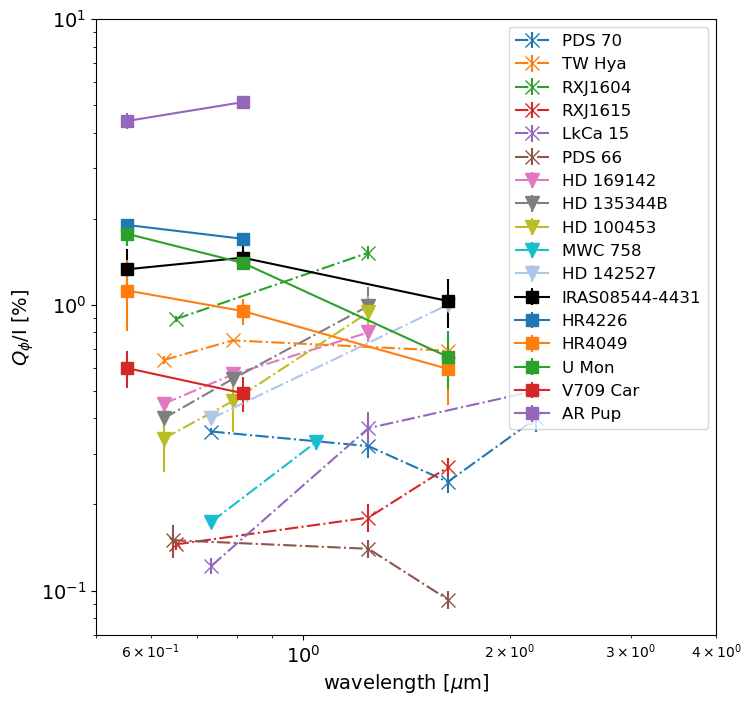

In [8]:

#Data from this study (unfortunately added manually so far, but has to be updated to read from files)
#IRAS08
wavedep_dict_IRAS08={'Band':['V','I','H'],
              'wavelength [mkm]':[ 0.554, 0.8168, 1.625],
              'unres_DoLP[%]':[0.95, 1.03, 0.63 ],
              'er_unres_DoLP[%]':[0.09, 0.06,0.09 ],
              'unres_AoLP':[159, 155,148],
              'er_unres_AoLP':[2.1,1.33,4.3],
              'corr_sumQ_phi/I[%]':[1.33,1.46, 1.03],
              'er_corr_sumQ_phi/I[%]':[0.23,0.14,0.2], #estimation for H
              'initial_sumQ_phi/I[%]':[0.51,0.67, 0.55],
              'er_initial_sumQ_phi/I[%]':[0.07,0.05, 0.1],#estimation for H
              'corr_sumPI/I[%]':[1.283,1.42, 1.001],
              'er_corr_sumPI/I[%]':[0.203,0.132,0.2],
               'unres_cor_sumQ_phi/I[%]':[0.317,0.484,0.449],
               'er_unres_cor_sumQ_phi/I[%]':[0.049,0.041,0.1],#estimation for H
               'unres_cor_sumPI/I[%]':[0.356,0.519,0.514],
               'er_unres_cor_sumPI/I[%]':[0.051,0.0457,0.1]
               }



wavedep_dict_AR_Pup={'Band':['V','I'],
              'wavelength [mkm]':[ 0.554, 0.8168],
              'unres_DoLP[%]':[2.388, 3.727],#here are the values calculated but not subtracted from the total
              'er_unres_DoLP[%]':[0.191, 0.179],
              'unres_AoLP':[56.922, 68.711],
              'er_unres_AoLP':[1.919, 1.541],
              'corr_sumQ_phi/I[%]':[4.391,5.211],
              'er_corr_sumQ_phi/I[%]':[0.343,0.269], 
              'initial_sumQ_phi/I[%]':[2.285, 2.901],
              'er_initial_sumQ_phi/I[%]':[0.161, 0.137],
              'corr_sumPI/I[%]':[4.392, 5.111],
              'er_corr_sumPI/I[%]':[0.279, 0.243],
              'initial_sumPI/I[%]':[3.047, 3.644],
              'er_initial_sumPI/I[%]':[0.184, 0.166],
              'unres_cor_sumQ_phi/I[%]':[np.nan,np.nan],
              'er_unres_cor_sumQ_phi/I[%]':[np.nan,np.nan],
              'unres_cor_sumPI/I[%]':[np.nan,np.nan],
              'er_unres_cor_sumPI/I[%]':[np.nan,np.nan]
               }


wavedep_dict_UMon={'Band':['V','I','H'],
               'wavelength [mkm]':[ 0.554, 0.8168, 1.625],
               'unres_DoLP[%]':[0.52,0.77,1.63 ],
               'er_unres_DoLP[%]':[0.05,0.04,0.07 ],
               'unres_AoLP':[161,167,178],
               'er_unres_AoLP':[3,2,50],
               'corr_sumQ_phi/I[%]':[1.23,1.05,0.567],
               'er_corr_sumQ_phi/I[%]':[0.1,0.05,0.15], #estimation for H
               'corr_sumPI/I[%]':[1.77,1.4,0.657],
               'er_corr_sumPI/I[%]':[0.16,0.07,0.15],
               'initial_sumQ_phi/I[%]':[0.349,0.538,0.502],
               'er_initial_sumQ_phi/I[%]':[0.038,0.032,0.1],
               'initial_sumPI/I[%]':[0.658 ,1.014,1.397],
               'er_initial_sumPI/I[%]':[0.058,0.045,0.1],
               'unres_cor_sumQ_phi/I[%]':[0.316,0.361,0.230],
               'er_unres_cor_sumQ_phi/I[%]':[0.021,0.015,0.1],#estimation for H
               'unres_cor_sumPI/I[%]':[0.536,0.548,0.339],
               'er_unres_cor_sumPI/I[%]':[0.046,0.025,0.1]
                }

wavedep_dict_HR4049_combined={'Band':['V','I','H'],
               'wavelength [mkm]':[ 0.554, 0.8168, 1.625],
               'unres_DoLP[%]':[0.11,0.23,0.17 ],
               'er_unres_DoLP[%]':[0.07,0.04,0.06 ],
               'unres_AoLP':[57,63,79],
               'er_unres_AoLP':[25,9,12],
               'corr_sumQ_phi/I[%]':[1.215,0.98,0.578],
               'er_corr_sumQ_phi/I[%]':[0.33,0.10,0.15], #estimation for H
               'corr_sumPI/I[%]':[1.121,0.95,0.596],
               'er_corr_sumPI/I[%]':[0.31,0.10,0.15],
               'initial_sumQ_phi/I[%]':[0.515,0.505,0.268],
               'er_initial_sumQ_phi/I[%]':[0.121,0.045,0.1],
               'initial_sumPI/I[%]':[0.575,0.620,0.375],
               'er_initial_sumPI/I[%]':[0.128,0.053,0.1],
               'unres_cor_sumQ_phi/I[%]':[0.503,0.475,0.249],
               'er_unres_cor_sumQ_phi/I[%]':[0.130,0.048,0.1],#estimation for H
               'unres_cor_sumPI/I[%]':[0.522,0.509,0.329],
               'er_unres_cor_sumPI/I[%]':[0.135,0.049,0.1]
                }

wavedep_dict_HR4049_07={'Band':['V','I','H'],
               'wavelength [mkm]':[ 0.554, 0.8168, 1.625],
               'unres_DoLP[%]':[0.196 ,0.241,0.17 ],
               'er_unres_DoLP[%]':[0.051,0.042,0.06 ],
               'unres_AoLP':[50.636,59.199,79],
               'er_unres_AoLP':[12.436,10.689,12],
               'corr_sumQ_phi/I[%]':[0.834,0.859,0.578],
               'er_corr_sumQ_phi/I[%]':[0.108,0.053,0.15], #estimation for H
               'corr_sumPI/I[%]':[0.796,0.849,0.596],
               'er_corr_sumPI/I[%]':[0.089,0.058,0.15],
               'initial_sumQ_phi/I[%]':[np.nan,np.nan,np.nan ],
               'er_initial_sumQ_phi/I[%]':[np.nan,np.nan,np.nan],
               'initial_sumPI/I[%]':[np.nan,np.nan,np.nan],
               'er_initial_sumPI/I[%]':[np.nan,np.nan,np.nan]
                }

wavedep_dict_HR4049_08={'Band':['V','I','H'],
               'wavelength [mkm]':[ 0.554, 0.8168, 1.625],
               'unres_DoLP[%]':[0.076,0.233,0.17 ],
               'er_unres_DoLP[%]':[0.042, 0.037,0.06 ],
               'unres_AoLP':[83.153,69.224,79],
               'er_unres_AoLP':[20.623,6.600,12],
               'corr_sumQ_phi/I[%]':[1.512,1.070,0.578],
               'er_corr_sumQ_phi/I[%]':[0.188,0.068,0.15], #estimation for H
               'corr_sumPI/I[%]':[1.418,1.038,0.596],
               'er_corr_sumPI/I[%]':[0.186,0.061,0.15],
               'initial_sumQ_phi/I[%]':[np.nan,np.nan,np.nan ],
               'er_initial_sumQ_phi/I[%]':[np.nan,np.nan,np.nan],
               'initial_sumPI/I[%]':[np.nan,np.nan,np.nan],
               'er_initial_sumPI/I[%]':[np.nan,np.nan,np.nan]
                }

wavedep_dict_V709_Car={'Band':['V','I'],
               'wavelength [mkm]':[ 0.554, 0.8168],
               'unres_DoLP[%]':[1.7,2.6],
               'er_unres_DoLP[%]':[0.16,0.1],
               'unres_AoLP':[139,140],
               'er_unres_AoLP':[0.9,0.6],
               'corr_sumQ_phi/I[%]':[0.5,0.4],
               'er_corr_sumQ_phi/I[%]':[0.06,0.04],
               'corr_sumPI/I[%]':[0.6,0.49],
               'er_corr_sumPI/I[%]':[0.09,0.07],
               'initial_sumQ_phi/I[%]':[0.664,0.949],
               'er_initial_sumQ_phi/I[%]':[0.040,0.029],
               'initial_sumPI/I[%]':[1.792,2.644],
               'er_initial_sumPI/I[%]':[0.108,0.084],
               'unres_cor_sumQ_phi/I[%]':[0.215,0.208],
               'er_unres_cor_sumQ_phi/I[%]':[0.019,0.013],#estimation for H
               'unres_cor_sumPI/I[%]':[0.288,0.252],
               'er_unres_cor_sumPI/I[%]':[0.034, 0.025]
                }

wavedep_dict_HR4226={'Band':['V','I'],
              'wavelength [mkm]':[0.554, 0.8168],
              'unres_DoLP[%]':[0.15,0.16],
              'er_unres_DoLP[%]':[0.056,0.037],
              'unres_AoLP':[168.4,160.9],
              'er_unres_AoLP':[60.4,5.87],
              'corr_sumQ_phi/I[%]':[1.77,1.63],
              'er_corr_sumQ_phi/I[%]':[0.119,0.062], 
              'initial_sumQ_phi/I[%]':[0.451,0.550],
              'er_initial_sumQ_phi/I[%]':[0.026,0.017],
              'corr_sumPI/I[%]':[1.9,1.7],
              'er_corr_sumPI/I[%]':[0.1,0.06],
              'initial_sumPI/I[%]':[0.548,0.651],
              'er_initial_sumPI/I[%]':[0.031,0.019],
               'unres_cor_sumQ_phi/I[%]':[0.439, 0.536],
               'er_unres_cor_sumQ_phi/I[%]':[0.025, 0.017],#estimation for H
               'unres_cor_sumPI/I[%]':[0.505, 0.605],
               'er_unres_cor_sumPI/I[%]':[0.025,0.016]
               }




wavedep_dict_AR_Pup_ref={'Band':['V','I'],
              'wavelength [mkm]':[ 0.554, 0.8168],
              'unres_DoLP[%]':[0.187,0.178 ],
              'er_unres_DoLP[%]':[0.054,0.035],
              'unres_AoLP':[104.779,],
              'er_unres_AoLP':[10.468,],
              'initial_sumQ_phi/I[%]':[0.106,0.163],
              'er_initial_sumQ_phi/I[%]':[0.014,0.010],
              'initial_sumPI/I[%]':[0.349,0.495],
              'er_initial_sumPI/I[%]':[0.027,0.021]
               }

wavedep_dict_HR4049_ref={'Band':['V','I'],
              'wavelength [mkm]':[ 0.554, 0.8168],
              'unres_DoLP[%]':[0.119,0.201],
              'er_unres_DoLP[%]':[0.029,0.025],
              'unres_AoLP':[53.328,54.274],
              'er_unres_AoLP':[9.412,4.424],
              'initial_sumQ_phi/I[%]':[0.078,0.120 ],
              'er_initial_sumQ_phi/I[%]':[0.017,0.008],
              'initial_sumPI/I[%]':[0.238,0.336],
              'er_initial_sumPI/I[%]':[0.031,0.015]
               }

wavedep_dict_V709_Car_ref={'Band':['V','I'],
              'wavelength [mkm]':[ 0.554, 0.8168],
              'unres_DoLP[%]':[0.137,0.082],
              'er_unres_DoLP[%]':[0.070,0.039],
              'unres_AoLP':[110.409,118.285],
              'er_unres_AoLP':[18.868,12.299],
              'initial_sumQ_phi/I[%]':[ 0.087,0.088],
              'er_initial_sumQ_phi/I[%]':[0.010,0.010],
              'initial_sumPI/I[%]':[0.292,0.272 ],
              'er_initial_sumPI/I[%]':[0.038,0.018]
               }

wavedep_dict_HR4226_ref={'Band':['V','I'],
              'wavelength [mkm]':[ 0.554, 0.8168],
              'unres_DoLP[%]':[0.217,0.148],
              'er_unres_DoLP[%]':[0.026,0.017 ],
              'unres_AoLP':[110.026,120.835],
              'er_unres_AoLP':[4.829,3.857],
              'initial_sumQ_phi/I[%]':[0.082,0.120 ],
              'er_initial_sumQ_phi/I[%]':[0.007,0.006],
              'initial_sumPI/I[%]':[0.301,0.379],
              'er_initial_sumPI/I[%]':[0.017,0.011]
               }

wavedep_dict_UMon_ref={'Band':['V','I'],
              'wavelength [mkm]':[ 0.554, 0.8168],
              'unres_DoLP[%]':[0.105,0.045 ],
              'er_unres_DoLP[%]':[0.043,0.016],
              'unres_AoLP':[131.927,150.836],
              'er_unres_AoLP':[13.409,7.720],
              'initial_sumQ_phi/I[%]':[0.066 ,0.109],
              'er_initial_sumQ_phi/I[%]':[0.007,0.007],
              'initial_sumPI/I[%]':[0.201,0.312 ],
              'er_initial_sumPI/I[%]':[0.018,0.008]
               }




plt.figure(figsize=(8,8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']

for ia, set in enumerate([ma_pds70,ma_tw_hyd,ma_rxj1604,ma_rxj1615,ma_LkCa15,ma_pds66]):
    wavelengths = [ma_wavelength[band]/1000 for band in set['Band']]
    plt.errorbar(wavelengths,set['sumQ_phi/I[%]'], yerr=set['er_sumQ_phi/I[%]'], fmt='-.x',label=set['star'], markersize=10, color=colors[ia])

for ia,set in enumerate([ma_HD169142,ma_HD135344B,ma_HD100453,ma_MWC758,ma_HD142527]):
    wavelengths = [ma_wavelength[band]/1000 for band in set['Band']]
    plt.errorbar(wavelengths,set['sumQ_phi/I[%]'], yerr=set['er_sumQ_phi/I[%]'], fmt='-.v',label=set['star'], markersize=10, color=colors[ia+6])

plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['corr_sumQ_phi/I[%]'], yerr=wavedep_dict_IRAS08['er_corr_sumQ_phi/I[%]'], fmt='-s',label='IRAS08544-4431', markersize=8, color='black')
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['corr_sumPI/I[%]'], yerr=wavedep_dict_HR4226['er_corr_sumPI/I[%]'], fmt='-s',label='HR4226', markersize=8)
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['corr_sumPI/I[%]'], yerr=wavedep_dict_HR4049_combined['er_corr_sumPI/I[%]'], fmt='-s',label='HR4049', markersize=8)
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['corr_sumPI/I[%]'], yerr=wavedep_dict_UMon['er_corr_sumPI/I[%]'], fmt='-s',label='U Mon', markersize=8)
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['corr_sumPI/I[%]'], yerr=wavedep_dict_V709_Car['er_corr_sumPI/I[%]'], fmt='-s',label='V709 Car', markersize=8)
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['corr_sumPI/I[%]'], yerr=wavedep_dict_AR_Pup['er_corr_sumPI/I[%]'], fmt='-s',label='AR Pup', markersize=8)

plt.xlim(5e-1, 4e0)
plt.ylim(7e-2, 10e0)
plt.ylabel(r'$Q_{\phi}$/I [%]',fontsize=14)
plt.xlabel(r'wavelength [$\mu$m]',fontsize=14)
plt.yscale('log')
plt.xscale('log')
# Set tick label font sizes for both major and minor ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.legend(fontsize=12)
plt.savefig(figfolder+'Qphi_comparison_Ma2023.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


## Plots

<>:64: SyntaxWarning: invalid escape sequence '\p'
<>:64: SyntaxWarning: invalid escape sequence '\p'
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_28406/3007726922.py:64: SyntaxWarning: invalid escape sequence '\p'
  mlines.Line2D([], [], color='black', marker='s', markersize=8, linestyle='-', label='$Q_{\phi}$/I'),


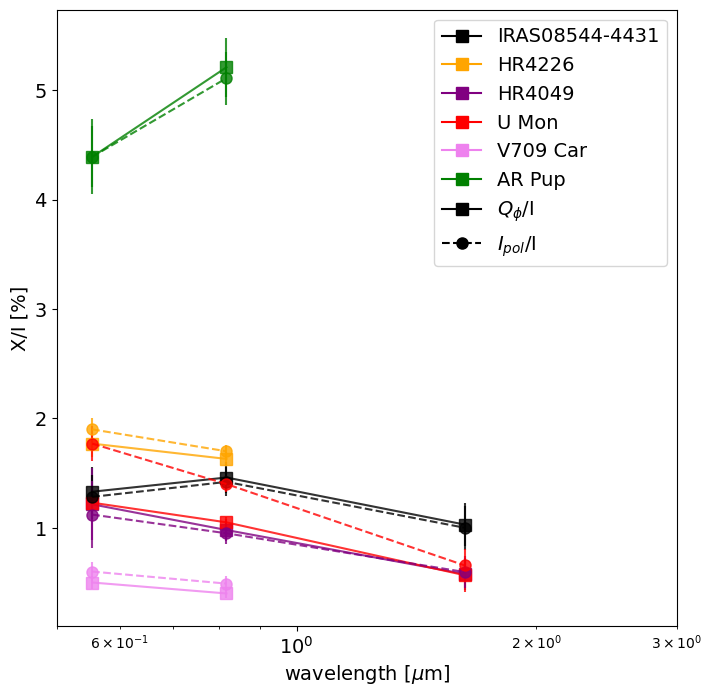

In [9]:

plt.figure(figsize=(8,8))

plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['corr_sumQ_phi/I[%]'],
             yerr=wavedep_dict_IRAS08['er_corr_sumQ_phi/I[%]'], fmt='-s',label='IRAS08544-4431',
             markersize=8, color='black',alpha=0.8)
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['corr_sumQ_phi/I[%]'],
             yerr=wavedep_dict_HR4226['er_corr_sumQ_phi/I[%]'], fmt='-s',label='HR4226',
             markersize=8, color='orange',alpha=0.8)
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['corr_sumQ_phi/I[%]'],
             yerr=wavedep_dict_HR4049_combined['er_corr_sumQ_phi/I[%]'], fmt='-s',label='HR4049',
             markersize=8,color='purple',alpha=0.8)
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['corr_sumQ_phi/I[%]'],
             yerr=wavedep_dict_UMon['er_corr_sumQ_phi/I[%]'], fmt='-s',label='U Mon',
             markersize=8, color='red',alpha=0.8)
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['corr_sumQ_phi/I[%]'],
             yerr=wavedep_dict_V709_Car['er_corr_sumQ_phi/I[%]'], fmt='-s',label='V709 Car', 
             markersize=8, color='violet',alpha=0.8)
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['corr_sumQ_phi/I[%]'], 
             yerr=wavedep_dict_AR_Pup['er_corr_sumQ_phi/I[%]'], fmt='-s',label='AR Pup',
             markersize=8, color='green',alpha=0.8)

plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['corr_sumPI/I[%]'],
             yerr=wavedep_dict_IRAS08['er_corr_sumPI/I[%]'], fmt='--o',label='IRAS08544-4431',
             markersize=8, color='black',alpha=0.8)
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['corr_sumPI/I[%]'],
             yerr=wavedep_dict_HR4226['er_corr_sumPI/I[%]'], fmt='--o',label='HR4226', 
             markersize=8, color='orange',alpha=0.8)
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['corr_sumPI/I[%]'],
             yerr=wavedep_dict_HR4049_combined['er_corr_sumPI/I[%]'], fmt='--o',label='HR4049',
             markersize=8,color='purple',alpha=0.8)
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['corr_sumPI/I[%]'],
             yerr=wavedep_dict_UMon['er_corr_sumPI/I[%]'], fmt='--o',label='U Mon',
             markersize=8, color='red',alpha=0.8)
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['corr_sumPI/I[%]'],
             yerr=wavedep_dict_V709_Car['er_corr_sumPI/I[%]'], fmt='--o',label='V709 Car', 
             markersize=8, color='violet',alpha=0.8)
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['corr_sumPI/I[%]'],
             yerr=wavedep_dict_AR_Pup['er_corr_sumPI/I[%]'], fmt='--o',label='AR Pup',
             markersize=8, color='green',alpha=0.8)



plt.xlim(5e-1, 3e0)
#plt.ylim(3e-1, 10e0)
plt.ylabel(r'X/I [%]',fontsize=14)
plt.xlabel(r'wavelength [$\mu$m]',fontsize=14)
#plt.yscale('log')
plt.xscale('log')
# Set tick label font sizes for both major and minor ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

star_legends = [
    mlines.Line2D([], [], color='black', marker='s', markersize=8, linestyle='-', label='IRAS08544-4431'),
    mlines.Line2D([], [], color='orange', marker='s', markersize=8, linestyle='-', label='HR4226'),
    mlines.Line2D([], [], color='purple', marker='s', markersize=8, linestyle='-', label='HR4049'),
    mlines.Line2D([], [], color='red', marker='s', markersize=8, linestyle='-', label='U Mon'),
    mlines.Line2D([], [], color='violet', marker='s', markersize=8, linestyle='-', label='V709 Car'),
    mlines.Line2D([], [], color='green', marker='s', markersize=8, linestyle='-', label='AR Pup')
]

# Create legend entries for the types of data (linestyles)
style_legends = [
    mlines.Line2D([], [], color='black', marker='s', markersize=8, linestyle='-', label='$Q_{\phi}$/I'),
    mlines.Line2D([], [], color='black', marker='o', markersize=8, linestyle='--', label='$I_{pol}$/I')
]

# Combine both legends
plt.legend(handles=star_legends + style_legends, fontsize=14, loc='best')

plt.savefig(figfolder+'qphi_vs_pi_after_smearing.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


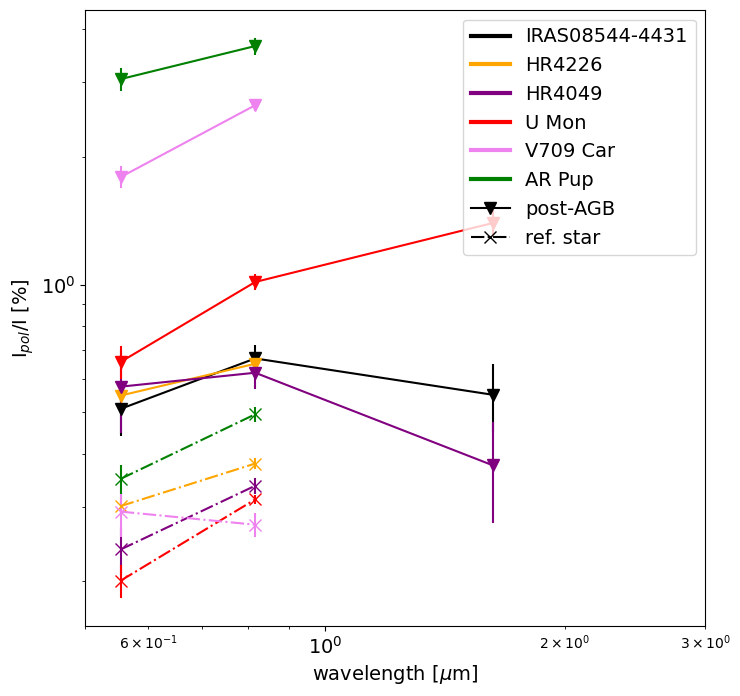

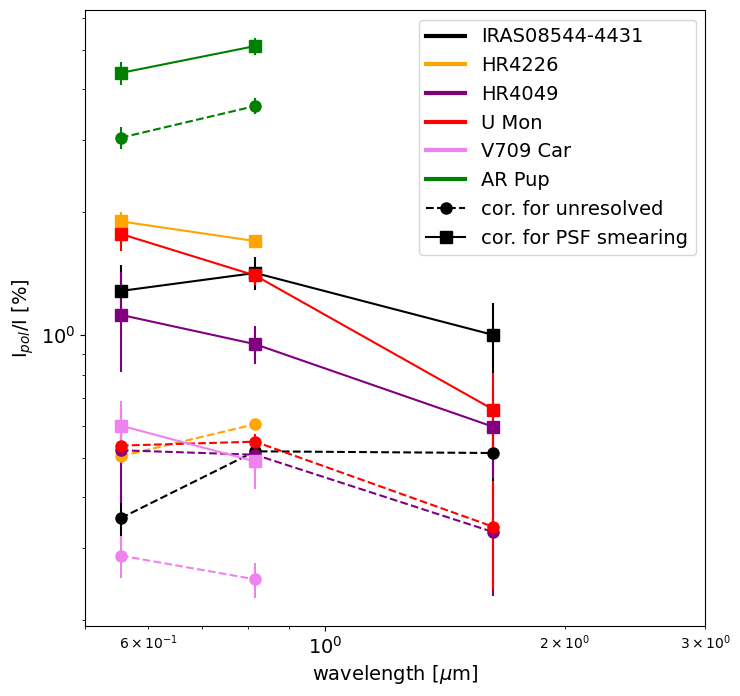

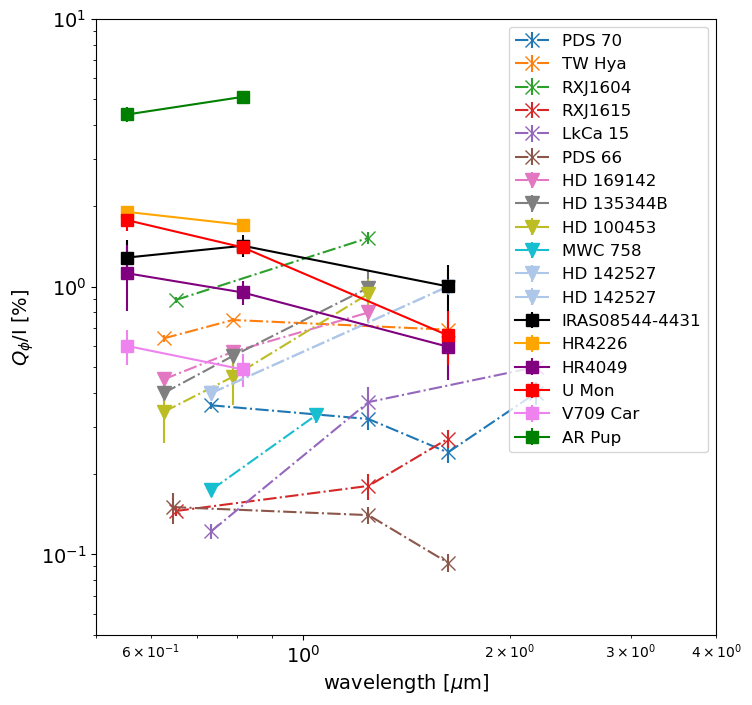

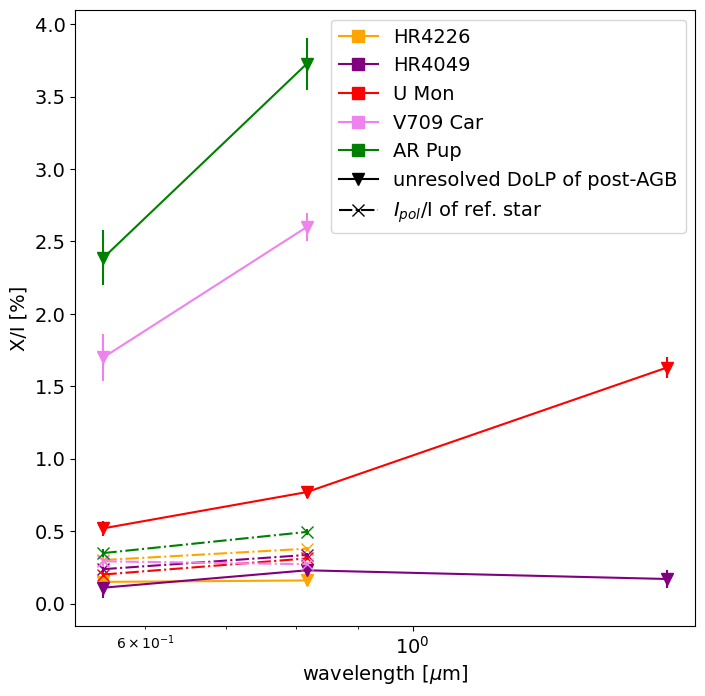

In [10]:


plt.figure(figsize=(8,8))

plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['initial_sumQ_phi/I[%]'], yerr=wavedep_dict_IRAS08['er_initial_sumQ_phi/I[%]'], fmt='-v',label='IRAS08544-4431', markersize=8, color='black')
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['initial_sumPI/I[%]'], yerr=wavedep_dict_HR4226['er_initial_sumPI/I[%]'], fmt='-v',label='HR4226', markersize=8, color='orange')
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['initial_sumPI/I[%]'], yerr=wavedep_dict_HR4049_combined['er_initial_sumPI/I[%]'], fmt='-v',label='HR4049', markersize=8,color='purple')
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['initial_sumPI/I[%]'], yerr=wavedep_dict_UMon['er_initial_sumPI/I[%]'], fmt='-v',label='U Mon', markersize=8, color='red')
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['initial_sumPI/I[%]'], yerr=wavedep_dict_V709_Car['er_initial_sumPI/I[%]'], fmt='-v',label='V709 Car', markersize=8, color='violet')
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['initial_sumPI/I[%]'], yerr=wavedep_dict_AR_Pup['er_initial_sumPI/I[%]'], fmt='-v',label='AR Pup', markersize=8, color='green')

plt.errorbar(wavedep_dict_HR4226_ref['wavelength [mkm]'],wavedep_dict_HR4226_ref['initial_sumPI/I[%]'], yerr=wavedep_dict_HR4226_ref['er_initial_sumPI/I[%]'], fmt='-.x',label='ref HR4226', markersize=8, color='orange')
plt.errorbar(wavedep_dict_HR4049_ref['wavelength [mkm]'],wavedep_dict_HR4049_ref['initial_sumPI/I[%]'], yerr=wavedep_dict_HR4049_ref['er_initial_sumPI/I[%]'], fmt='-.x',label='ref HR4049', markersize=8,color='purple')
plt.errorbar(wavedep_dict_UMon_ref['wavelength [mkm]'],wavedep_dict_UMon_ref['initial_sumPI/I[%]'], yerr=wavedep_dict_UMon_ref['er_initial_sumPI/I[%]'], fmt='-.x',label='ref U Mon', markersize=8, color='red')
plt.errorbar(wavedep_dict_V709_Car_ref['wavelength [mkm]'],wavedep_dict_V709_Car_ref['initial_sumPI/I[%]'], yerr=wavedep_dict_V709_Car_ref['er_initial_sumPI/I[%]'], fmt='-.x',label='ref V709 Car', markersize=8, color='violet')
plt.errorbar(wavedep_dict_AR_Pup_ref['wavelength [mkm]'],wavedep_dict_AR_Pup_ref['initial_sumPI/I[%]'], yerr=wavedep_dict_AR_Pup_ref['er_initial_sumPI/I[%]'], fmt='-.x',label='ref AR Pup', markersize=8, color='green')

plt.xlim(5e-1, 3e0)
#plt.ylim(5e-2, 10e0)
plt.ylabel(r'I$_{pol}$/I [%]',fontsize=14)
plt.xlabel(r'wavelength [$\mu$m]',fontsize=14)
plt.yscale('log')
plt.xscale('log')
# Set tick label font sizes for both major and minor ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('initial pi for sci and ref')

star_legends = [
    mlines.Line2D([], [], color='black', linestyle='-',linewidth=3, label='IRAS08544-4431'),
    mlines.Line2D([], [], color='orange', linestyle='-',linewidth=3, label='HR4226'),
    mlines.Line2D([], [], color='purple', linestyle='-',linewidth=3, label='HR4049'),
    mlines.Line2D([], [], color='red', linestyle='-',linewidth=3, label='U Mon'),
    mlines.Line2D([], [], color='violet', linestyle='-',linewidth=3, label='V709 Car'),
    mlines.Line2D([], [], color='green', linestyle='-',linewidth=3, label='AR Pup')
]

# Create legend entries for the types of data (linestyles)
style_legends = [
    mlines.Line2D([], [], color='black', marker='v', markersize=8, linestyle='-', label='post-AGB'),
    mlines.Line2D([], [], color='black', marker='x', markersize=8, linestyle='-.', label='ref. star')
]
# Combine both legends
plt.legend(handles=star_legends + style_legends, fontsize=14, loc='best')
plt.savefig(figfolder+'pi_initial_with_ref.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()



plt.figure(figsize=(8,8))

plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['unres_cor_sumPI/I[%]'], yerr=wavedep_dict_IRAS08['er_unres_cor_sumPI/I[%]'], fmt='--o',label='IRAS08544-4431', markersize=8, color='black')
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['unres_cor_sumPI/I[%]'], yerr=wavedep_dict_HR4226['er_unres_cor_sumPI/I[%]'], fmt='--o',label='HR4226', markersize=8, color='orange')
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['unres_cor_sumPI/I[%]'], yerr=wavedep_dict_HR4049_combined['er_unres_cor_sumPI/I[%]'], fmt='--o',label='HR4049', markersize=8,color='purple')
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['unres_cor_sumPI/I[%]'], yerr=wavedep_dict_UMon['er_unres_cor_sumPI/I[%]'], fmt='--o',label='U Mon', markersize=8, color='red')
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['unres_cor_sumPI/I[%]'], yerr=wavedep_dict_V709_Car['er_unres_cor_sumPI/I[%]'], fmt='--o',label='V709 Car', markersize=8, color='violet')
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['initial_sumPI/I[%]'], yerr=wavedep_dict_AR_Pup['er_initial_sumPI/I[%]'], fmt='--o',label='AR Pup', markersize=8, color='green')

plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['corr_sumPI/I[%]'], yerr=wavedep_dict_IRAS08['er_corr_sumPI/I[%]'], fmt='-s',label='IRAS08544-4431', markersize=8, color='black')
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['corr_sumPI/I[%]'], yerr=wavedep_dict_HR4226['er_corr_sumPI/I[%]'], fmt='-s',label='HR4226', markersize=8, color='orange')
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['corr_sumPI/I[%]'], yerr=wavedep_dict_HR4049_combined['er_corr_sumPI/I[%]'], fmt='-s',label='HR4049', markersize=8,color='purple')
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['corr_sumPI/I[%]'], yerr=wavedep_dict_UMon['er_corr_sumPI/I[%]'], fmt='-s',label='U Mon', markersize=8, color='red')
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['corr_sumPI/I[%]'], yerr=wavedep_dict_V709_Car['er_corr_sumPI/I[%]'], fmt='-s',label='V709 Car', markersize=8, color='violet')
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['corr_sumPI/I[%]'], yerr=wavedep_dict_AR_Pup['er_corr_sumPI/I[%]'], fmt='-s',label='AR Pup', markersize=8, color='green')

plt.xlim(5e-1, 3e0)
#plt.ylim(5e-2, 10e0)
plt.ylabel(r'I$_{pol}$/I [%]',fontsize=14)
plt.xlabel(r'wavelength [$\mu$m]',fontsize=14)
plt.yscale('log')
plt.xscale('log')
# Set tick label font sizes for both major and minor ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
#plt.title('corr for unresolved q_phi')

# Create legend entries for the types of data (linestyles)
style_legends = [
    mlines.Line2D([], [], color='black', marker='o', markersize=8, linestyle='--', label='cor. for unresolved'),
    mlines.Line2D([], [], color='black', marker='s', markersize=8, linestyle='-', label='cor. for PSF smearing')
]
# Combine both legends
plt.legend(handles=star_legends + style_legends, fontsize=14, loc='best')

plt.savefig(figfolder+'pi+-smearing.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()



plt.figure(figsize=(8,8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']

for ia, set in enumerate([ma_pds70,ma_tw_hyd,ma_rxj1604,ma_rxj1615,ma_LkCa15,ma_pds66]):
    wavelengths = [ma_wavelength[band]/1000 for band in set['Band']]
    plt.errorbar(wavelengths,set['sumQ_phi/I[%]'], yerr=set['er_sumQ_phi/I[%]'], fmt='-.x',label=set['star'], markersize=10, color=colors[ia])

for ia,set in enumerate([ma_HD169142,ma_HD135344B,ma_HD100453,ma_MWC758,ma_HD142527]):
    wavelengths = [ma_wavelength[band]/1000 for band in set['Band']]
    plt.errorbar(wavelengths,set['sumQ_phi/I[%]'], yerr=set['er_sumQ_phi/I[%]'], fmt='-.v',label=set['star'], markersize=10, color=colors[ia+6])
    
plt.errorbar(wavelengths,set['sumQ_phi/I[%]'], yerr=set['er_sumQ_phi/I[%]'], fmt='-.v',label=set['star'], markersize=10, color=colors[ia+6])
plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['corr_sumPI/I[%]'], yerr=wavedep_dict_IRAS08['er_corr_sumPI/I[%]'], fmt='-s',label='IRAS08544-4431', markersize=8, color='black')
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['corr_sumPI/I[%]'], yerr=wavedep_dict_HR4226['er_corr_sumPI/I[%]'], fmt='-s',label='HR4226', markersize=8, color='orange')
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['corr_sumPI/I[%]'], yerr=wavedep_dict_HR4049_combined['er_corr_sumPI/I[%]'], fmt='-s',label='HR4049', markersize=8,color='purple')
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['corr_sumPI/I[%]'], yerr=wavedep_dict_UMon['er_corr_sumPI/I[%]'], fmt='-s',label='U Mon', markersize=8, color='red')
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['corr_sumPI/I[%]'], yerr=wavedep_dict_V709_Car['er_corr_sumPI/I[%]'], fmt='-s',label='V709 Car', markersize=8, color='violet')
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['corr_sumPI/I[%]'], yerr=wavedep_dict_AR_Pup['er_corr_sumPI/I[%]'], fmt='-s',label='AR Pup', markersize=8, color='green')

plt.xlim(5e-1, 4e0)
plt.ylim(5e-2, 10e0)
plt.ylabel(r'$Q_{\phi}$/I [%]',fontsize=14)
plt.xlabel(r'wavelength [$\mu$m]',fontsize=14)
plt.yscale('log')
plt.xscale('log')
# Set tick label font sizes for both major and minor ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.legend(fontsize=12)
plt.savefig(figfolder+'final_pi+YSO_Ma2023.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()




plt.figure(figsize=(8,8))

#plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['unres_DoLP[%]'], yerr=wavedep_dict_IRAS08['er_unres_DoLP[%]'], fmt='-v',label='IRAS08544-4431', markersize=8, color='black')
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['unres_DoLP[%]'], yerr=wavedep_dict_HR4226['er_unres_DoLP[%]'], fmt='-v',label='HR4226', markersize=8, color='orange')
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['unres_DoLP[%]'], yerr=wavedep_dict_HR4049_combined['er_unres_DoLP[%]'], fmt='-v',label='HR4049', markersize=8,color='purple')
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['unres_DoLP[%]'], yerr=wavedep_dict_UMon['er_unres_DoLP[%]'], fmt='-v',label='U Mon', markersize=8, color='red')
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['unres_DoLP[%]'], yerr=wavedep_dict_V709_Car['er_unres_DoLP[%]'], fmt='-v',label='V709 Car', markersize=8, color='violet')
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['unres_DoLP[%]'], yerr=wavedep_dict_AR_Pup['er_unres_DoLP[%]'], fmt='-v',label='AR Pup', markersize=8, color='green')

plt.errorbar(wavedep_dict_HR4226_ref['wavelength [mkm]'],wavedep_dict_HR4226_ref['initial_sumPI/I[%]'], yerr=wavedep_dict_HR4226_ref['er_initial_sumPI/I[%]'], fmt='-.x',label='ref HR4226', markersize=8, color='orange')
plt.errorbar(wavedep_dict_HR4049_ref['wavelength [mkm]'],wavedep_dict_HR4049_ref['initial_sumPI/I[%]'], yerr=wavedep_dict_HR4049_ref['er_initial_sumPI/I[%]'], fmt='-.x',label='ref HR4049', markersize=8,color='purple')
plt.errorbar(wavedep_dict_UMon_ref['wavelength [mkm]'],wavedep_dict_UMon_ref['initial_sumPI/I[%]'], yerr=wavedep_dict_UMon_ref['er_initial_sumPI/I[%]'], fmt='-.x',label='ref U Mon', markersize=8, color='red')
plt.errorbar(wavedep_dict_V709_Car_ref['wavelength [mkm]'],wavedep_dict_V709_Car_ref['initial_sumPI/I[%]'], yerr=wavedep_dict_V709_Car_ref['er_initial_sumPI/I[%]'], fmt='-.x',label='ref V709 Car', markersize=8, color='violet')
plt.errorbar(wavedep_dict_AR_Pup_ref['wavelength [mkm]'],wavedep_dict_AR_Pup_ref['initial_sumPI/I[%]'], yerr=wavedep_dict_AR_Pup_ref['er_initial_sumPI/I[%]'], fmt='-.x',label='ref AR Pup', markersize=8, color='green')

#plt.xlim(5e-1, 3e0)
#plt.ylim(5e-2, 10e0)
plt.ylabel(r'X/I [%]',fontsize=14)
plt.xlabel(r'wavelength [$\mu$m]',fontsize=14)
#plt.yscale('log')
plt.xscale('log')
# Set tick label font sizes for both major and minor ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('initial pi for sci and ref')
star_legends = [
    mlines.Line2D([], [], color='orange', marker='s', markersize=8, linestyle='-', label='HR4226'),
    mlines.Line2D([], [], color='purple', marker='s', markersize=8, linestyle='-', label='HR4049'),
    mlines.Line2D([], [], color='red', marker='s', markersize=8, linestyle='-', label='U Mon'),
    mlines.Line2D([], [], color='violet', marker='s', markersize=8, linestyle='-', label='V709 Car'),
    mlines.Line2D([], [], color='green', marker='s', markersize=8, linestyle='-', label='AR Pup')
]
# Create legend entries for the types of data (linestyles)
style_legends = [
    mlines.Line2D([], [], color='black', marker='v', markersize=8, linestyle='-', label='unresolved DoLP of post-AGB'),
    mlines.Line2D([], [], color='black', marker='x', markersize=8, linestyle='-.', label='$I_{pol}$/I of ref. star')
]
# Combine both legends
plt.legend(handles=star_legends + style_legends, fontsize=14, loc='best')
plt.savefig(figfolder+'unres_DOLP_with_ref.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


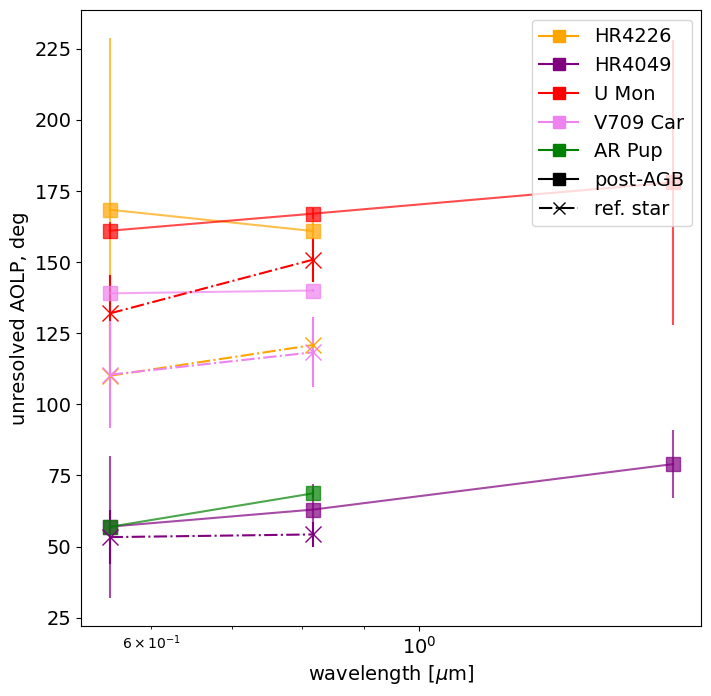

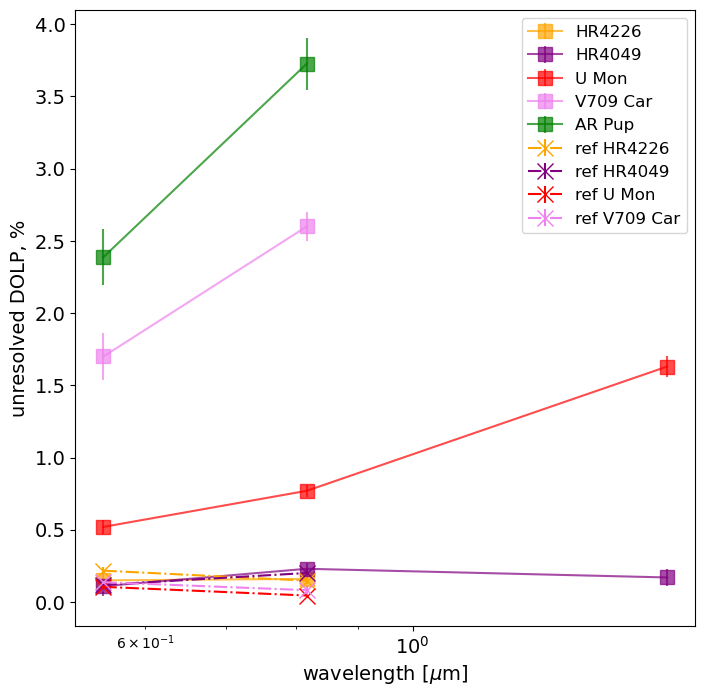

In [11]:

plt.figure(figsize=(8,8))

#plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['unres_AoLP'], yerr=wavedep_dict_IRAS08['er_unres_AoLP'], fmt='-s',label='IRAS08544-4431', markersize=10, color='black',alpha=0.7)
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['unres_AoLP'], yerr=wavedep_dict_HR4226['er_unres_AoLP'], fmt='-s',label='HR4226', markersize=10, color='orange',alpha=0.7)
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['unres_AoLP'], yerr=wavedep_dict_HR4049_combined['er_unres_AoLP'], fmt='-s',label='HR4049', markersize=10,color='purple',alpha=0.7)
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['unres_AoLP'], yerr=wavedep_dict_UMon['er_unres_AoLP'], fmt='-s',label='U Mon', markersize=10, color='red',alpha=0.7)
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['unres_AoLP'], yerr=wavedep_dict_V709_Car['er_unres_AoLP'], fmt='-s',label='V709 Car', markersize=10, color='violet',alpha=0.7)
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['unres_AoLP'], yerr=wavedep_dict_AR_Pup['er_unres_AoLP'], fmt='-s',label='AR Pup', markersize=10, color='green',alpha=0.7)

#plt.errorbar(wavedep_dict_HR4049_07['wavelength [mkm]'],wavedep_dict_HR4049_07['unres_AoLP'], yerr=wavedep_dict_HR4049_07['er_unres_AoLP'], fmt='-s',label='HR4049 07', markersize=8,color='darkorchid')
#plt.errorbar(wavedep_dict_HR4049_08['wavelength [mkm]'],wavedep_dict_HR4049_08['unres_AoLP'], yerr=wavedep_dict_HR4049_08['er_unres_AoLP'], fmt='-s',label='HR4049 08', markersize=8,color='mediumorchid')

plt.errorbar(wavedep_dict_HR4226_ref['wavelength [mkm]'],wavedep_dict_HR4226_ref['unres_AoLP'], yerr=wavedep_dict_HR4226_ref['er_unres_AoLP'], fmt='-.x',label='ref HR4226', markersize=12, color='orange')
plt.errorbar(wavedep_dict_HR4049_ref['wavelength [mkm]'],wavedep_dict_HR4049_ref['unres_AoLP'], yerr=wavedep_dict_HR4049_ref['er_unres_AoLP'], fmt='-.x',label='ref HR4049', markersize=12,color='purple')
plt.errorbar(wavedep_dict_UMon_ref['wavelength [mkm]'],wavedep_dict_UMon_ref['unres_AoLP'], yerr=wavedep_dict_UMon_ref['er_unres_AoLP'], fmt='-.x',label='ref U Mon', markersize=12, color='red')
plt.errorbar(wavedep_dict_V709_Car_ref['wavelength [mkm]'],wavedep_dict_V709_Car_ref['unres_AoLP'], yerr=wavedep_dict_V709_Car_ref['er_unres_AoLP'], fmt='-.x',label='V709 Car', markersize=12, color='violet')
#plt.errorbar(wavedep_dict_AR_Pup_ref['wavelength [mkm]'],wavedep_dict_AR_Pup_ref['unres_AoLP'], yerr=wavedep_dict_AR_Pup_ref['er_unres_AoLP'], fmt='-.x',label='AR Pup', markersize=12, color='green')

star_legends = [
    mlines.Line2D([], [], color='orange', marker='s', markersize=8, linestyle='-', label='HR4226'),
    mlines.Line2D([], [], color='purple', marker='s', markersize=8, linestyle='-', label='HR4049'),
    mlines.Line2D([], [], color='red', marker='s', markersize=8, linestyle='-', label='U Mon'),
    mlines.Line2D([], [], color='violet', marker='s', markersize=8, linestyle='-', label='V709 Car'),
    mlines.Line2D([], [], color='green', marker='s', markersize=8, linestyle='-', label='AR Pup')
]


style_legends = [
    mlines.Line2D([], [], color='black', marker='s', markersize=8, linestyle='-', label='post-AGB'),
    mlines.Line2D([], [], color='black', marker='x', markersize=8, linestyle='-.', label='ref. star')
]
# Combine both legends
plt.legend(handles=star_legends + style_legends, fontsize=14, loc='upper right')
#plt.xlim(5e-1, 4e0)
#plt.ylim(7e-2, 4e0)
plt.ylabel(r'unresolved AOLP, deg',fontsize=14)
plt.xlabel(r'wavelength [$\mu$m]',fontsize=14)
#plt.yscale('log')
plt.xscale('log')
# Set tick label font sizes for both major and minor ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.savefig(figfolder+'AoLP_wavelendep.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()



plt.figure(figsize=(8,8))

#plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['unres_DoLP[%]'], yerr=wavedep_dict_IRAS08['er_unres_DoLP[%]'], fmt='-s',label='IRAS08544-4431', markersize=10, color='black',alpha=0.7)
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['unres_DoLP[%]'], yerr=wavedep_dict_HR4226['er_unres_DoLP[%]'], fmt='-s',label='HR4226', markersize=10, color='orange',alpha=0.7)
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['unres_DoLP[%]'], yerr=wavedep_dict_HR4049_combined['er_unres_DoLP[%]'], fmt='-s',label='HR4049', markersize=10,color='purple',alpha=0.7)
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['unres_DoLP[%]'], yerr=wavedep_dict_UMon['er_unres_DoLP[%]'], fmt='-s',label='U Mon', markersize=10, color='red',alpha=0.7)
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['unres_DoLP[%]'], yerr=wavedep_dict_V709_Car['er_unres_DoLP[%]'], fmt='-s',label='V709 Car', markersize=10, color='violet',alpha=0.7)
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['unres_DoLP[%]'], yerr=wavedep_dict_AR_Pup['er_unres_DoLP[%]'], fmt='-s',label='AR Pup', markersize=10, color='green',alpha=0.7)

#plt.errorbar(wavedep_dict_HR4049_07['wavelength [mkm]'],wavedep_dict_HR4049_07['unres_DoLP[%]'], yerr=wavedep_dict_HR4049_07['er_unres_DoLP[%]'], fmt='-s',label='HR4049 07', markersize=8,color='darkorchid')
#plt.errorbar(wavedep_dict_HR4049_08['wavelength [mkm]'],wavedep_dict_HR4049_08['unres_DoLP[%]'], yerr=wavedep_dict_HR4049_08['er_unres_DoLP[%]'], fmt='-s',label='HR4049 08', markersize=8,color='mediumorchid')

plt.errorbar(wavedep_dict_HR4226_ref['wavelength [mkm]'],wavedep_dict_HR4226_ref['unres_DoLP[%]'], yerr=wavedep_dict_HR4226_ref['er_unres_DoLP[%]'], fmt='-.x',label='ref HR4226', markersize=12, color='orange',alpha=1)
plt.errorbar(wavedep_dict_HR4049_ref['wavelength [mkm]'],wavedep_dict_HR4049_ref['unres_DoLP[%]'], yerr=wavedep_dict_HR4049_ref['er_unres_DoLP[%]'], fmt='-.x',label='ref HR4049', markersize=12,color='purple',alpha=1)
plt.errorbar(wavedep_dict_UMon_ref['wavelength [mkm]'],wavedep_dict_UMon_ref['unres_DoLP[%]'], yerr=wavedep_dict_UMon_ref['er_unres_DoLP[%]'], fmt='-.x',label='ref U Mon', markersize=12, color='red',alpha=1)
plt.errorbar(wavedep_dict_V709_Car_ref['wavelength [mkm]'],wavedep_dict_V709_Car_ref['unres_DoLP[%]'], yerr=wavedep_dict_V709_Car_ref['er_unres_DoLP[%]'], fmt='-.x',label='ref V709 Car', markersize=12, color='violet',alpha=1)
#plt.errorbar(wavedep_dict_AR_Pup_ref['wavelength [mkm]'],wavedep_dict_AR_Pup_ref['unres_DoLP[%]'], yerr=wavedep_dict_AR_Pup_ref['er_unres_DoLP[%]'], fmt='-.x',label='AR Pup', markersize=12, color='green')



#plt.xlim(5e-1, 4e0)
#plt.ylim(7e-2, 4e0)
plt.ylabel(r'unresolved DOLP, %',fontsize=14)
plt.xlabel(r'wavelength [$\mu$m]',fontsize=14)
#plt.yscale('log')
plt.xscale('log')
# Set tick label font sizes for both major and minor ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.legend(fontsize=12)
plt.savefig(figfolder+'DoLP_wavelendep.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


# Color

In [12]:
#color index for the corr_sumQ_phi/I[%]

print('corr_sumQ_phi/I[%]')


def color_index(a1,a2,lamb1,lamb2):
    n_color=(np.log10(a2)-np.log10(a1))/np.log10(lamb2/lamb1)
    return n_color

#,'HR4049_07','HR4049_08'
stars=['UMon','HR4049_combined','V709_Car','HR4226', 'IRAS08544-4431', 'AR_Pup_dc_notnorm']
dict_for_color={'UMon':wavedep_dict_UMon,'HR4049_combined':wavedep_dict_HR4049_combined,'HR4049_07':wavedep_dict_HR4049_07,'HR4049_08':wavedep_dict_HR4049_08,'V709_Car':wavedep_dict_V709_Car,'HR4226':wavedep_dict_HR4226,'IRAS08544-4431':wavedep_dict_IRAS08, 'AR_Pup_dc_notnorm':wavedep_dict_AR_Pup}

dict_nVI_q={}
dict_nVH_q={}
dict_nIH_q={}


for star in stars:
    print(star)
    wave_df=pd.DataFrame(dict_for_color[star]).set_index('Band')
    #for the V and I
    nVI=color_index(wave_df.loc['V','corr_sumQ_phi/I[%]'],wave_df.loc['I','corr_sumQ_phi/I[%]'],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['I','wavelength [mkm]'])
    nVI_min=color_index(wave_df.loc['V','corr_sumQ_phi/I[%]']+wave_df.loc['V','er_corr_sumQ_phi/I[%]'],wave_df.loc['I','corr_sumQ_phi/I[%]']-wave_df.loc['I','er_corr_sumQ_phi/I[%]'],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['I','wavelength [mkm]'])
    nVI_max=color_index(wave_df.loc['V','corr_sumQ_phi/I[%]']-wave_df.loc['V','er_corr_sumQ_phi/I[%]'],wave_df.loc['I','corr_sumQ_phi/I[%]']+wave_df.loc['I','er_corr_sumQ_phi/I[%]'],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['I','wavelength [mkm]'])
    error= max(abs(nVI-nVI_min),abs(nVI-nVI_max))
    print('nVI',nVI,'+-',error)
    dict_nVI_q[star]=[nVI, error]
    try:
        #for the I and H
        nIH=color_index(wave_df.loc['I','corr_sumQ_phi/I[%]'],wave_df.loc['H','corr_sumQ_phi/I[%]'],wave_df.loc['I','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        nIH_min=color_index(wave_df.loc['I','corr_sumQ_phi/I[%]']+wave_df.loc['I','er_corr_sumQ_phi/I[%]'],wave_df.loc['H','corr_sumQ_phi/I[%]']-wave_df.loc['H','er_corr_sumQ_phi/I[%]'],wave_df.loc['I','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        nIH_max=color_index(wave_df.loc['I','corr_sumQ_phi/I[%]']-wave_df.loc['I','er_corr_sumQ_phi/I[%]'],wave_df.loc['H','corr_sumQ_phi/I[%]']+wave_df.loc['H','er_corr_sumQ_phi/I[%]'],wave_df.loc['I','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        error= max(abs(nIH-nIH_min),abs(nIH-nIH_max))
        print('nIH',nIH, '+-',error)
        dict_nIH_q[star]=[nIH, error]


         #for the V and H
        nVH=color_index(wave_df.loc['V','corr_sumQ_phi/I[%]'],wave_df.loc['H','corr_sumQ_phi/I[%]'],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        nVH_min=color_index(wave_df.loc['V','corr_sumQ_phi/I[%]']+wave_df.loc['V','er_corr_sumQ_phi/I[%]'],wave_df.loc['H','corr_sumQ_phi/I[%]']-wave_df.loc['H','er_corr_sumQ_phi/I[%]'],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        nVH_max=color_index(wave_df.loc['V','corr_sumQ_phi/I[%]']-wave_df.loc['V','er_corr_sumQ_phi/I[%]'],wave_df.loc['H','corr_sumQ_phi/I[%]']+wave_df.loc['H','er_corr_sumQ_phi/I[%]'],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        error= max(abs(nVH-nVH_min),abs(nVH-nVH_max))
        dict_nVH_q[star]=[nVH, error]
        print('nVH',nVH, '+-',error)
    except KeyError as err:
        print('No data in H-band')
        dict_nIH_q[star]=[np.nan, np.nan]
        dict_nVH_q[star]=[np.nan, np.nan]

corr_sumQ_phi/I[%]
UMon
nVI -0.40755267842508575 +- 0.338244582651514
nIH -0.895790177457218 +- 0.5143322145256363
nVH -0.719646213459316 +- 0.3581808614406552
HR4049_combined
nVI -0.5536589562621922 +- 1.0665736987643415
nIH -0.7675572457525642 +- 0.5780381453690427
nVH -0.6903880551887619 +- 0.5089115328220088
V709_Car
nVI -0.5747721522273223 +- 0.5747721522273223
No data in H-band
HR4226
nVI -0.21224434198231168 +- 0.2754288531664457
No data in H-band
IRAS08544-4431
nVI 0.24021223076767995 +- 0.7249214649745042
nIH -0.5071862822116894 +- 0.4469683193686511
nVH -0.23754346079116745 +- 0.348848447933998
AR_Pup_dc_notnorm
nVI 0.4410142686757589 +- 0.33914825498941126
No data in H-band


In [13]:
#color index for the corr_sumPI/I[%]
print('corr_sumPI/I[%]')

column_name='corr_sumPI/I[%]'
column_name_er='er_corr_sumPI/I[%]'

def color_index(a1,a2,lamb1,lamb2):
    n_color=(np.log10(a2)-np.log10(a1))/np.log10(lamb2/lamb1)
    return n_color

dict_nVI_pi={}
dict_nVH_pi={}
dict_nIH_pi={}

for star in stars:
    print(star)
    wave_df=pd.DataFrame(dict_for_color[star]).set_index('Band')
    #for the V and I
    nVI=color_index(wave_df.loc['V',column_name],wave_df.loc['I',column_name],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['I','wavelength [mkm]'])
    nVI_min=color_index(wave_df.loc['V',column_name]+wave_df.loc['V',column_name_er],wave_df.loc['I',column_name]-wave_df.loc['I',column_name_er],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['I','wavelength [mkm]'])
    nVI_max=color_index(wave_df.loc['V',column_name]-wave_df.loc['V',column_name_er],wave_df.loc['I',column_name]+wave_df.loc['I',column_name_er],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['I','wavelength [mkm]'])
    error= max(abs(nVI-nVI_min),abs(nVI-nVI_max))
    print('nVI',nVI,'+-',error)
    dict_nVI_pi[star]=[nVI, error]
    try:
        #for the I and H
        nIH=color_index(wave_df.loc['I',column_name],wave_df.loc['H',column_name],wave_df.loc['I','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        nIH_min=color_index(wave_df.loc['I',column_name]+wave_df.loc['I',column_name_er],wave_df.loc['H',column_name]-wave_df.loc['H',column_name_er],wave_df.loc['I','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        nIH_max=color_index(wave_df.loc['I',column_name]-wave_df.loc['I',column_name_er],wave_df.loc['H',column_name]+wave_df.loc['H',column_name_er],wave_df.loc['I','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        error= max(abs(nIH-nIH_min),abs(nIH-nIH_max))
        print('nIH',nIH, '+-',error)
        dict_nIH_pi[star]=[nIH, error]


         #for the V and H
        nVH=color_index(wave_df.loc['V',column_name],wave_df.loc['H',column_name],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        nVH_min=color_index(wave_df.loc['V',column_name]+wave_df.loc['V',column_name_er],wave_df.loc['H',column_name]-wave_df.loc['H',column_name_er],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        nVH_max=color_index(wave_df.loc['V',column_name]-wave_df.loc['V',column_name_er],wave_df.loc['H',column_name]+wave_df.loc['H',column_name_er],wave_df.loc['V','wavelength [mkm]'],wave_df.loc['H','wavelength [mkm]'])
        error= max(abs(nVH-nVH_min),abs(nVH-nVH_max))
        print('nVH',nVH, '+-',error)
        dict_nVH_pi[star]=[nVH, error]
    except KeyError as err:
        print('No data in H-band')
        dict_nIH_pi[star]=[np.nan, np.nan]
        dict_nVH_pi[star]=[np.nan, np.nan]

corr_sumPI/I[%]
UMon
nVI -0.6040428704639267 +- 0.36971817479918356
nIH -1.0998368677552646 +- 0.4477062581786868
nVH -0.9209667068553257 +- 0.32126566552746516
HR4049_combined
nVI -0.42633134351480384 +- 1.0916010763556634
nIH -0.6777764867518379 +- 0.566976082904252
nVH -0.5870613238534704 +- 0.5094267383087933
V709_Car
nVI -0.5216610853239292 +- 0.7625650833808754
No data in H-band
HR4226
nVI -0.28649448885545026 +- 0.22860900819195648
No data in H-band
IRAS08544-4431
nVI 0.26132935556509673 +- 0.6726112795831637
nIH -0.508319838159777 +- 0.45325703061802236
nVH -0.23064952373444803 +- 0.343630926460065
AR_Pup_dc_notnorm
nVI 0.3905173210619923 +- 0.2886974254799833
No data in H-band


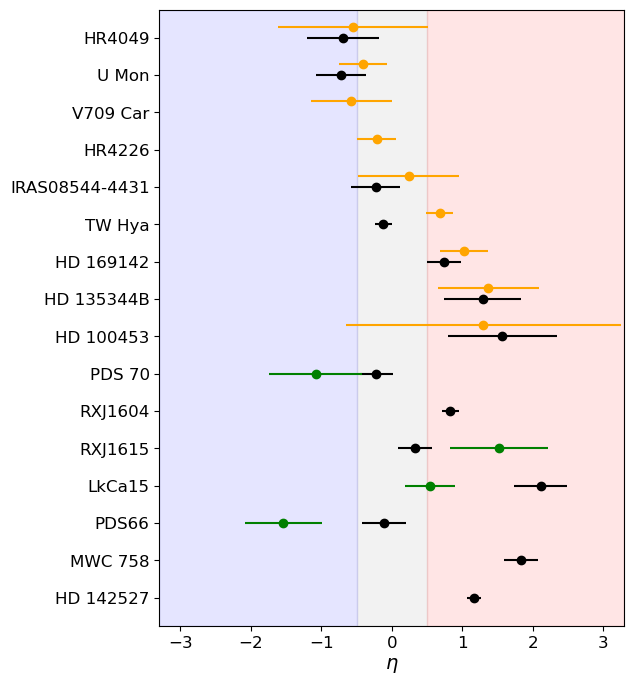

In [14]:
import matplotlib.transforms as transforms

figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+'wavelength_dep/'

#WITH Q_PHI
color_grad = {
    'Vis': {
        'star': ['AR_Pup_dc_notnorm','HR4049','U Mon','V709 Car','HR4226','IRAS08544-4431','PDS 70', 'TW Hya', 'RXJ1604', 'RXJ1615', 'LkCa15', 'PDS66', 'HD 169142', 'HD 135344B', 'HD 100453', 'MWC 758', 'HD 142527'],
        'n': [dict_nVI_q['AR_Pup_dc_notnorm'][0],dict_nVI_q['HR4049_combined'][0],dict_nVI_q['UMon'][0],dict_nVI_q['V709_Car'][0],dict_nVI_q['HR4226'][0],0.24,np.nan, 0.68, np.nan, np.nan, np.nan, np.nan, 1.02, 1.37, 1.3],
        'er': [dict_nVI_q['AR_Pup_dc_notnorm'][1],dict_nVI_q['HR4049_combined'][1],dict_nVI_q['UMon'][1],dict_nVI_q['V709_Car'][1],dict_nVI_q['HR4226'][1],0.72,np.nan, 0.19, np.nan, np.nan, np.nan, np.nan, 0.34, 0.72, 1.95]
    },
    'Vis-IR': {
        'star': ['AR_Pup_dc_notnorm','HR4049','U Mon','V709 Car','HR4226','IRAS08544-4431','PDS 70', 'TW Hya', 'RXJ1604', 'RXJ1615', 'LkCa15', 'PDS66', 'HD 169142', 'HD 135344B', 'HD 100453', 'MWC 758', 'HD 142527'],
        'n': [dict_nVH_q['AR_Pup_dc_notnorm'][0],dict_nVH_q['HR4049_combined'][0],dict_nVH_q['UMon'][0],dict_nVH_q['V709_Car'][0],dict_nVH_q['HR4226'][0],-0.23,-0.22,-0.12,0.83,0.33,2.11,-0.11,0.74,1.29,1.57,1.83,1.16],
        'er': [dict_nVH_q['AR_Pup_dc_notnorm'][1],dict_nVH_q['HR4049_combined'][1],dict_nVH_q['UMon'][1],dict_nVH_q['V709_Car'][1],dict_nVH_q['HR4226'][1],0.35,0.23,0.12,0.12,0.24,0.38,0.31,0.24,0.55,0.78,0.24,0.10]
    },
    'IR': {
        'star': ['AR_Pup_dc_notnorm','HR4049','U Mon','V709 Car','HR4226','IRAS08544-4431','PDS 70', 'TW Hya', 'RXJ1604', 'RXJ1615', 'LkCa15', 'PDS66', 'HD 169142', 'HD 135344B', 'HD 100453', 'MWC 758', 'HD 142527'],
        'n': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,-1.08,np.nan,np.nan,1.52,0.54,-1.54,np.nan,np.nan,np.nan,np.nan,np.nan],
        'er': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,0.66,np.nan,np.nan,0.7,0.35,0.55,np.nan,np.nan,np.nan,np.nan,np.nan]
    }
}


fig, ax = plt.subplots(figsize=(6,8))
offset = lambda p: transforms.ScaledTranslation(0,p/72., plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

star_filtered = [star for star, n in zip(color_grad['Vis']['star'], color_grad['Vis']['n']) if n is not np.nan]
n_filtered = [n for n in color_grad['Vis']['n'] if n is not np.nan]
er_filtered = [er for er in color_grad['Vis']['er'] if er is not np.nan]

ax.errorbar(n_filtered, star_filtered, xerr=er_filtered, fmt="o",color='orange',transform=trans+offset(8))

star_filtered = [star for star, n in zip(color_grad['Vis-IR']['star'], color_grad['Vis-IR']['n']) if n is not np.nan]
n_filtered = [n for n in color_grad['Vis-IR']['n'] if n is not np.nan]
er_filtered = [er for er in color_grad['Vis-IR']['er'] if er is not np.nan]

ax.errorbar(n_filtered, star_filtered, xerr=er_filtered, fmt="o",color='black')


star_filtered = [star for star, n in zip(color_grad['IR']['star'], color_grad['IR']['n']) if n is not np.nan]
n_filtered = [n for n in color_grad['IR']['n'] if n is not np.nan]
er_filtered = [er for er in color_grad['IR']['er'] if er is not np.nan]

ax.errorbar(n_filtered, star_filtered, xerr=er_filtered, fmt="o",color='green')

ax.set_xlim(-3.3,3.3)
ax.axvspan(-3.3, -0.5, alpha=0.1, color='blue')
ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray')
ax.axvspan(0.5, 3.3, alpha=0.1, color='red')
ax.invert_yaxis()
plt.xlabel(r'$\eta$',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.savefig(figfolder+'color_comparison_Ma2023.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


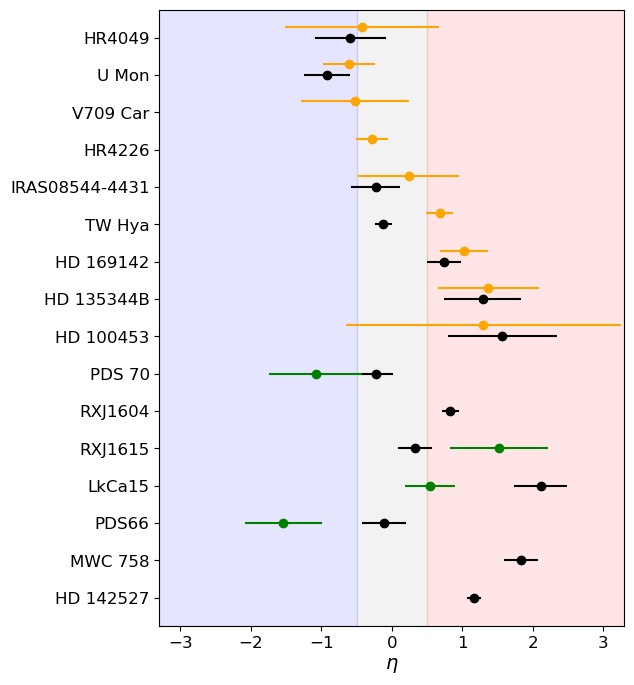

In [15]:


#WITH PI
color_grad = {
    'Vis': {
        'star': ['AR_Pup_dc_notnorm','HR4049','U Mon','V709 Car','HR4226','IRAS08544-4431','PDS 70', 'TW Hya', 'RXJ1604', 'RXJ1615', 'LkCa15', 'PDS66', 'HD 169142', 'HD 135344B', 'HD 100453', 'MWC 758', 'HD 142527'],
        'n': [dict_nVI_pi['AR_Pup_dc_notnorm'][0],dict_nVI_pi['HR4049_combined'][0],dict_nVI_pi['UMon'][0],dict_nVI_pi['V709_Car'][0],dict_nVI_pi['HR4226'][0],0.24,np.nan, 0.68, np.nan, np.nan, np.nan, np.nan, 1.02, 1.37, 1.3],
        'er': [dict_nVI_pi['AR_Pup_dc_notnorm'][1],dict_nVI_pi['HR4049_combined'][1],dict_nVI_pi['UMon'][1],dict_nVI_pi['V709_Car'][1],dict_nVI_pi['HR4226'][1],0.72,np.nan, 0.19, np.nan, np.nan, np.nan, np.nan, 0.34, 0.72, 1.95]
    },
    'Vis-IR': {
        'star': ['AR_Pup_dc_notnorm','HR4049','U Mon','V709 Car','HR4226','IRAS08544-4431','PDS 70', 'TW Hya', 'RXJ1604', 'RXJ1615', 'LkCa15', 'PDS66', 'HD 169142', 'HD 135344B', 'HD 100453', 'MWC 758', 'HD 142527'],
        'n': [dict_nVH_pi['AR_Pup_dc_notnorm'][0],dict_nVH_pi['HR4049_combined'][0],dict_nVH_pi['UMon'][0],dict_nVH_pi['V709_Car'][0],dict_nVH_pi['HR4226'][0],-0.23,-0.22,-0.12,0.83,0.33,2.11,-0.11,0.74,1.29,1.57,1.83,1.16],
        'er': [dict_nVH_pi['AR_Pup_dc_notnorm'][1],dict_nVH_pi['HR4049_combined'][1],dict_nVH_pi['UMon'][1],dict_nVH_pi['V709_Car'][1],dict_nVH_pi['HR4226'][1],0.35,0.23,0.12,0.12,0.24,0.38,0.31,0.24,0.55,0.78,0.24,0.10]
    },
    'IR': {
        'star': ['AR_Pup_dc_notnorm','HR4049','U Mon','V709 Car','HR4226','IRAS08544-4431','PDS 70', 'TW Hya', 'RXJ1604', 'RXJ1615', 'LkCa15', 'PDS66', 'HD 169142', 'HD 135344B', 'HD 100453', 'MWC 758', 'HD 142527'],
        'n': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,-1.08,np.nan,np.nan,1.52,0.54,-1.54,np.nan,np.nan,np.nan,np.nan,np.nan],
        'er': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,0.66,np.nan,np.nan,0.7,0.35,0.55,np.nan,np.nan,np.nan,np.nan,np.nan]
    }
}



fig, ax = plt.subplots(figsize=(6,8))
offset = lambda p: transforms.ScaledTranslation(0,p/72., plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

star_filtered = [star for star, n in zip(color_grad['Vis']['star'], color_grad['Vis']['n']) if n is not np.nan]
n_filtered = [n for n in color_grad['Vis']['n'] if n is not np.nan]
er_filtered = [er for er in color_grad['Vis']['er'] if er is not np.nan]

ax.errorbar(n_filtered, star_filtered, xerr=er_filtered, fmt="o",color='orange',transform=trans+offset(8))

star_filtered = [star for star, n in zip(color_grad['Vis-IR']['star'], color_grad['Vis-IR']['n']) if n is not np.nan]
n_filtered = [n for n in color_grad['Vis-IR']['n'] if n is not np.nan]
er_filtered = [er for er in color_grad['Vis-IR']['er'] if er is not np.nan]

ax.errorbar(n_filtered, star_filtered, xerr=er_filtered, fmt="o",color='black')


star_filtered = [star for star, n in zip(color_grad['IR']['star'], color_grad['IR']['n']) if n is not np.nan]
n_filtered = [n for n in color_grad['IR']['n'] if n is not np.nan]
er_filtered = [er for er in color_grad['IR']['er'] if er is not np.nan]

ax.errorbar(n_filtered, star_filtered, xerr=er_filtered, fmt="o",color='green')

ax.set_xlim(-3.3,3.3)
ax.axvspan(-3.3, -0.5, alpha=0.1, color='blue')
ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray')
ax.axvspan(0.5, 3.3, alpha=0.1, color='red')
ax.invert_yaxis()
plt.xlabel(r'$\eta$',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.savefig(figfolder+'color_comparison_Ma2023_pi.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()




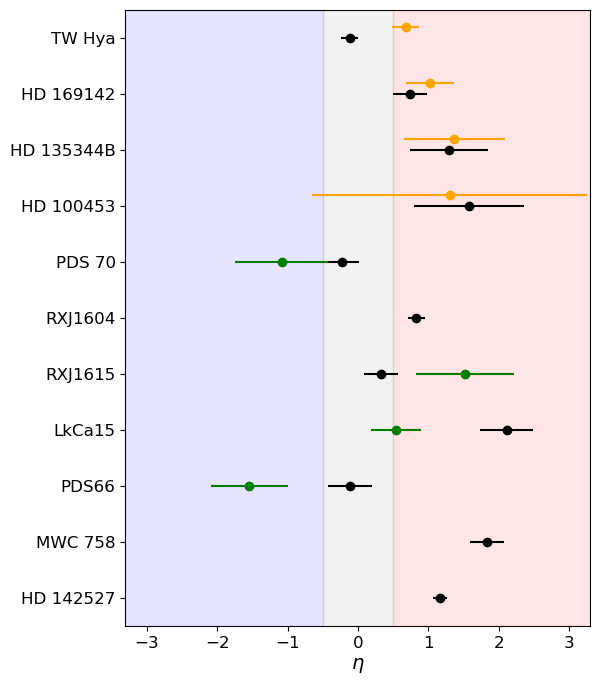

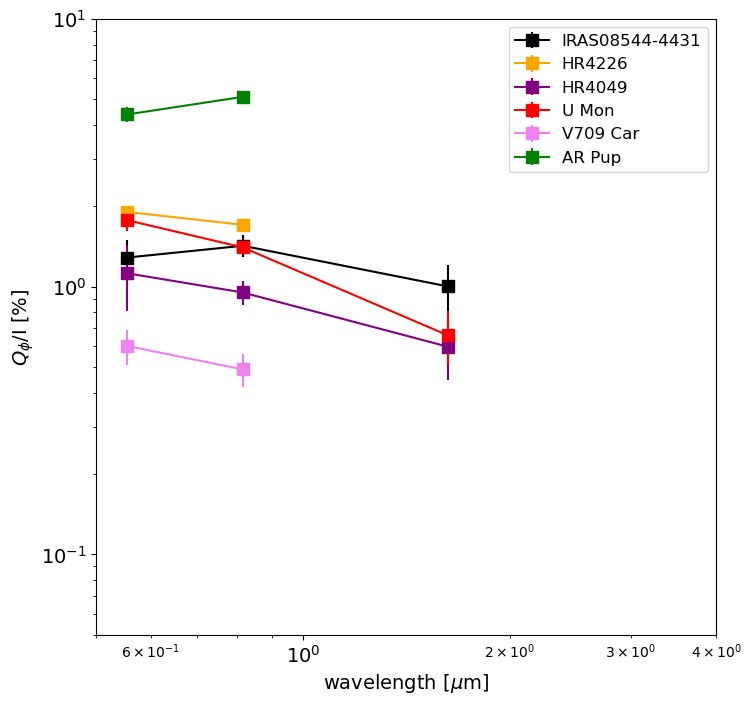

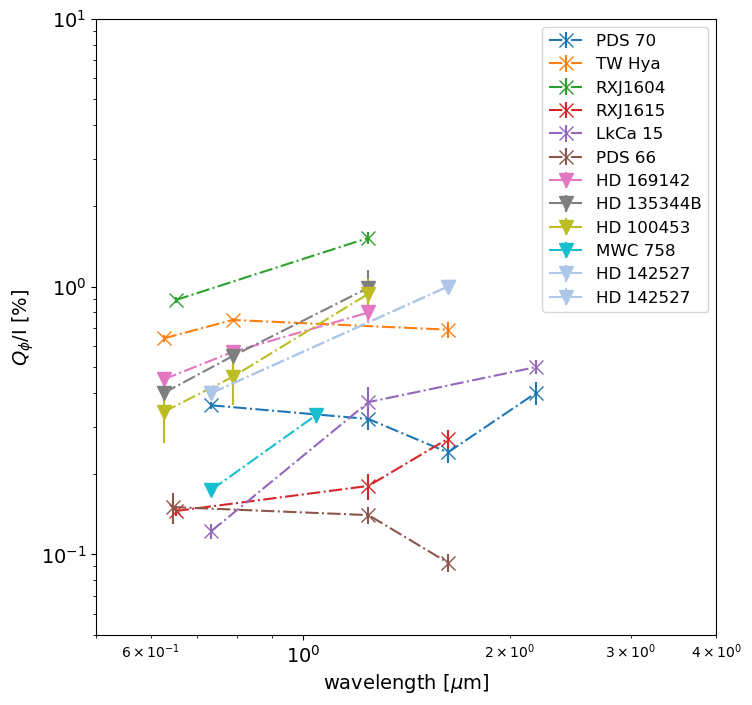

In [16]:
#WONLY 
color_grad = {
    'Vis': {
        'star': ['AR_Pup_dc_notnorm','HR4049','U Mon','V709 Car','HR4226','IRAS08544-4431','PDS 70', 'TW Hya', 'RXJ1604', 'RXJ1615', 'LkCa15', 'PDS66', 'HD 169142', 'HD 135344B', 'HD 100453', 'MWC 758', 'HD 142527'],
        'n': [dict_nVI_pi['AR_Pup_dc_notnorm'][0],dict_nVI_pi['HR4049_combined'][0],dict_nVI_pi['UMon'][0],dict_nVI_pi['V709_Car'][0],dict_nVI_pi['HR4226'][0],0.24,np.nan, 0.68, np.nan, np.nan, np.nan, np.nan, 1.02, 1.37, 1.3],
        'er': [dict_nVI_pi['AR_Pup_dc_notnorm'][1],dict_nVI_pi['HR4049_combined'][1],dict_nVI_pi['UMon'][1],dict_nVI_pi['V709_Car'][1],dict_nVI_pi['HR4226'][1],0.72,np.nan, 0.19, np.nan, np.nan, np.nan, np.nan, 0.34, 0.72, 1.95]
    },
    'Vis-IR': {
        'star': ['AR_Pup_dc_notnorm','HR4049','U Mon','V709 Car','HR4226','IRAS08544-4431','PDS 70', 'TW Hya', 'RXJ1604', 'RXJ1615', 'LkCa15', 'PDS66', 'HD 169142', 'HD 135344B', 'HD 100453', 'MWC 758', 'HD 142527'],
        'n': [dict_nVH_pi['AR_Pup_dc_notnorm'][0],dict_nVH_pi['HR4049_combined'][0],dict_nVH_pi['UMon'][0],dict_nVH_pi['V709_Car'][0],dict_nVH_pi['HR4226'][0],-0.23,-0.22,-0.12,0.83,0.33,2.11,-0.11,0.74,1.29,1.57,1.83,1.16],
        'er': [dict_nVH_pi['AR_Pup_dc_notnorm'][1],dict_nVH_pi['HR4049_combined'][1],dict_nVH_pi['UMon'][1],dict_nVH_pi['V709_Car'][1],dict_nVH_pi['HR4226'][1],0.35,0.23,0.12,0.12,0.24,0.38,0.31,0.24,0.55,0.78,0.24,0.10]
    },
    'IR': {
        'star': ['AR_Pup_dc_notnorm','HR4049','U Mon','V709 Car','HR4226','IRAS08544-4431','PDS 70', 'TW Hya', 'RXJ1604', 'RXJ1615', 'LkCa15', 'PDS66', 'HD 169142', 'HD 135344B', 'HD 100453', 'MWC 758', 'HD 142527'],
        'n': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,-1.08,np.nan,np.nan,1.52,0.54,-1.54,np.nan,np.nan,np.nan,np.nan,np.nan],
        'er': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,0.66,np.nan,np.nan,0.7,0.35,0.55,np.nan,np.nan,np.nan,np.nan,np.nan]
    }
}

start_index = color_grad['Vis']['star'].index('PDS 70')

# Slice the color_grad dictionary to include only targets from PDS 70 onwards
for key in color_grad:
    for sub_key in color_grad[key]:
        color_grad[key][sub_key] = color_grad[key][sub_key][start_index:]


fig, ax = plt.subplots(figsize=(6,8))
offset = lambda p: transforms.ScaledTranslation(0,p/72., plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

star_filtered = [star for star, n in zip(color_grad['Vis']['star'], color_grad['Vis']['n']) if n is not np.nan]
n_filtered = [n for n in color_grad['Vis']['n'] if n is not np.nan]
er_filtered = [er for er in color_grad['Vis']['er'] if er is not np.nan]

ax.errorbar(n_filtered, star_filtered, xerr=er_filtered, fmt="o",color='orange',transform=trans+offset(8))

star_filtered = [star for star, n in zip(color_grad['Vis-IR']['star'], color_grad['Vis-IR']['n']) if n is not np.nan]
n_filtered = [n for n in color_grad['Vis-IR']['n'] if n is not np.nan]
er_filtered = [er for er in color_grad['Vis-IR']['er'] if er is not np.nan]

ax.errorbar(n_filtered, star_filtered, xerr=er_filtered, fmt="o",color='black')


star_filtered = [star for star, n in zip(color_grad['IR']['star'], color_grad['IR']['n']) if n is not np.nan]
n_filtered = [n for n in color_grad['IR']['n'] if n is not np.nan]
er_filtered = [er for er in color_grad['IR']['er'] if er is not np.nan]

ax.errorbar(n_filtered, star_filtered, xerr=er_filtered, fmt="o",color='green')

ax.set_xlim(-3.3,3.3)
ax.axvspan(-3.3, -0.5, alpha=0.1, color='blue')
ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray')
ax.axvspan(0.5, 3.3, alpha=0.1, color='red')
ax.invert_yaxis()
plt.xlabel(r'$\eta$',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.savefig(figfolder+'color_Ma2023.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

plt.figure(figsize=(8,8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
    
plt.errorbar(wavedep_dict_IRAS08['wavelength [mkm]'],wavedep_dict_IRAS08['corr_sumPI/I[%]'], yerr=wavedep_dict_IRAS08['er_corr_sumPI/I[%]'], fmt='-s',label='IRAS08544-4431', markersize=8, color='black')
plt.errorbar(wavedep_dict_HR4226['wavelength [mkm]'],wavedep_dict_HR4226['corr_sumPI/I[%]'], yerr=wavedep_dict_HR4226['er_corr_sumPI/I[%]'], fmt='-s',label='HR4226', markersize=8, color='orange')
plt.errorbar(wavedep_dict_HR4049_combined['wavelength [mkm]'],wavedep_dict_HR4049_combined['corr_sumPI/I[%]'], yerr=wavedep_dict_HR4049_combined['er_corr_sumPI/I[%]'], fmt='-s',label='HR4049', markersize=8,color='purple')
plt.errorbar(wavedep_dict_UMon['wavelength [mkm]'],wavedep_dict_UMon['corr_sumPI/I[%]'], yerr=wavedep_dict_UMon['er_corr_sumPI/I[%]'], fmt='-s',label='U Mon', markersize=8, color='red')
plt.errorbar(wavedep_dict_V709_Car['wavelength [mkm]'],wavedep_dict_V709_Car['corr_sumPI/I[%]'], yerr=wavedep_dict_V709_Car['er_corr_sumPI/I[%]'], fmt='-s',label='V709 Car', markersize=8, color='violet')
plt.errorbar(wavedep_dict_AR_Pup['wavelength [mkm]'],wavedep_dict_AR_Pup['corr_sumPI/I[%]'], yerr=wavedep_dict_AR_Pup['er_corr_sumPI/I[%]'], fmt='-s',label='AR Pup', markersize=8, color='green')

plt.xlim(5e-1, 4e0)
plt.ylim(5e-2, 10e0)
plt.ylabel(r'$Q_{\phi}$/I [%]',fontsize=14)
plt.xlabel(r'wavelength [$\mu$m]',fontsize=14)
plt.yscale('log')
plt.xscale('log')
# Set tick label font sizes for both major and minor ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.legend(fontsize=12)
plt.savefig(figfolder+'final_pi.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()




plt.figure(figsize=(8,8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']

for ia, set in enumerate([ma_pds70,ma_tw_hyd,ma_rxj1604,ma_rxj1615,ma_LkCa15,ma_pds66]):
    wavelengths = [ma_wavelength[band]/1000 for band in set['Band']]
    plt.errorbar(wavelengths,set['sumQ_phi/I[%]'], yerr=set['er_sumQ_phi/I[%]'], fmt='-.x',label=set['star'], markersize=10, color=colors[ia])

for ia,set in enumerate([ma_HD169142,ma_HD135344B,ma_HD100453,ma_MWC758,ma_HD142527]):
    wavelengths = [ma_wavelength[band]/1000 for band in set['Band']]
    plt.errorbar(wavelengths,set['sumQ_phi/I[%]'], yerr=set['er_sumQ_phi/I[%]'], fmt='-.v',label=set['star'], markersize=10, color=colors[ia+6])
    
plt.errorbar(wavelengths,set['sumQ_phi/I[%]'], yerr=set['er_sumQ_phi/I[%]'], fmt='-.v',label=set['star'], markersize=10, color=colors[ia+6])

plt.xlim(5e-1, 4e0)
plt.ylim(5e-2, 10e0)
plt.ylabel(r'$Q_{\phi}$/I [%]',fontsize=14)
plt.xlabel(r'wavelength [$\mu$m]',fontsize=14)
plt.yscale('log')
plt.xscale('log')
# Set tick label font sizes for both major and minor ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.legend(fontsize=12)
plt.savefig(figfolder+'YSO_Ma2023.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()





## Only for post-AGBs

V709_Car
HR4226
AR_Pup_dc_notnorm
IRAS08544-4431
UMon
HR4049_combined


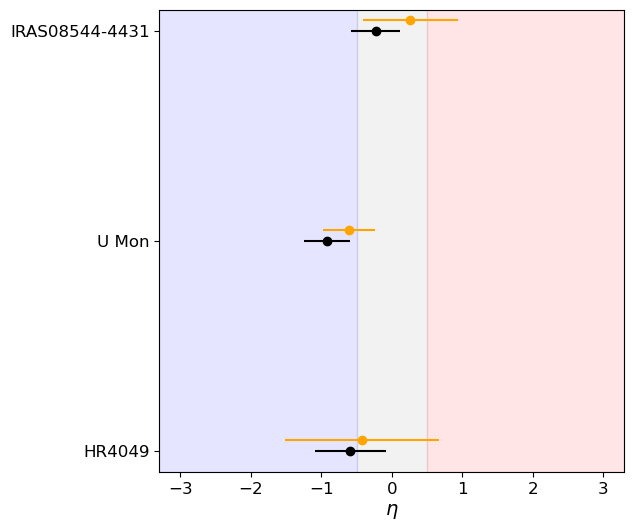

In [17]:
# WITH PI

# define stars to analyse
stars=['V709_Car','HR4226', 'AR_Pup_dc_notnorm','IRAS08544-4431','UMon','HR4049_combined']
starnames={'AR_Pup_dc_notnorm':'AR Pup','IRAS08544-4431':'IRAS08544-4431','UMon':'U Mon','HR4049_combined':'HR4049','V709_Car':'V709 Car','HR4226':'HR4226'}

fig, ax = plt.subplots(figsize=(6,6))
offset = lambda p: transforms.ScaledTranslation(0,p/72., plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

#
for star in stars:
    print(star)
    ax.errorbar(dict_nVI_pi[star][0], starnames[star], xerr=dict_nVI_pi[star][1], fmt="o",color='orange',transform=trans+offset(8))
    ax.errorbar(dict_nVH_pi[star][0], starnames[star], xerr=dict_nVH_pi[star][1], fmt="o",color='black')

ax.set_xlim(-3.3,3.3)
ax.axvspan(-3.3, -0.5, alpha=0.1, color='blue')
ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray')
ax.axvspan(0.5, 3.3, alpha=0.1, color='red')
ax.invert_yaxis()
plt.xlabel(r'$\eta$',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.savefig(figfolder+'colors_pi.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

# Orientation and value of unresolved polarisation for all wavelength
- V - white
- I - yellow
- H - red


white
dolp  0.52  pm  0.05
aolp  161  pm  3
gold
dolp  0.77  pm  0.04
aolp  167  pm  2
red
dolp  1.63  pm  0.07
aolp  178  pm  50


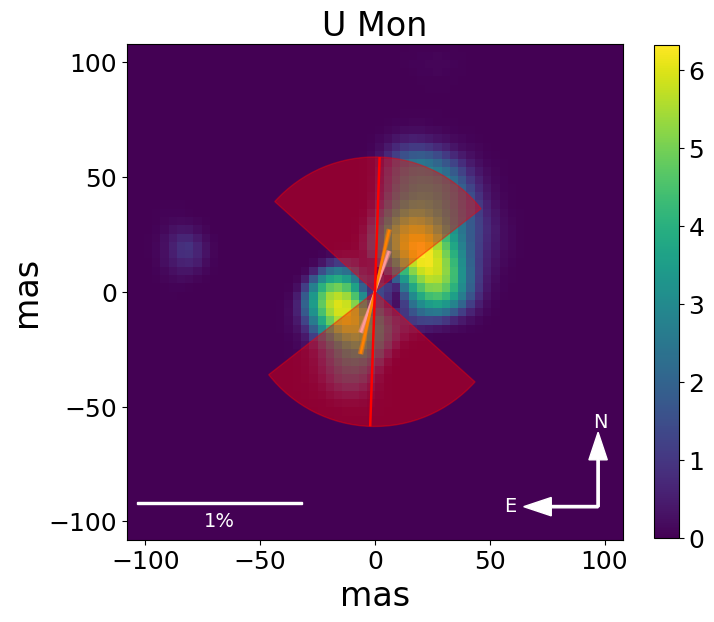

In [23]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Polygon, Wedge
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties
from skimage.transform import rescale, resize, downscale_local_mean

camera='ZIMPOL/'

def Loadimage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data
    return fit

def northeast2(lim,ps,coef=1, width=1):
    x_ar=(lim-3) * ps
    y_ar=(-lim+4) * ps
    plt.arrow(x_ar, y_ar, 0, 3*coef*ps, color='white',width=width,head_width=8, length_includes_head=True,head_length=12)
    plt.text(x_ar-0.2*coef * ps,y_ar+3.2*coef * ps,'N',fontsize=14,color="white")        
    plt.arrow(x_ar, y_ar, -3*coef*ps, 0, color='white',width=width,head_width=8, length_includes_head=True,head_length=12)
    plt.text(x_ar-3.8 *coef* ps,y_ar-0.2 *coef* ps,'E',fontsize=14,color="white") 

# Images of the mean_combined data

figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/wavelength_dep'
ps=3.6                                              # ZIMPOL
# stars=['UMon','HR4049_combined','V709_Car','HR4226','AR_Pup_dc_notnorm']
#plot_with_unres_Aolp(q_phi_for_multiwave_plot,aolp_unres,dolp_unres,lim,12.27)
stars = ['01.SCI_AR_Pup']
stars= ['01.SCI_UMon']
starnames = {'01.SCI_AR_Pup':'AR Pup','01.SCI_UMon':'U Mon'}
dict_for_plot={'01.SCI_UMon':wavedep_dict_UMon,'HR4049_combined':wavedep_dict_HR4049_combined,'V709_Car':wavedep_dict_V709_Car,'HR4226':wavedep_dict_HR4226,'01.SCI_AR_Pup':wavedep_dict_AR_Pup}
dolp_coef={'01.SCI_UMon':20,'HR4049_combined':150,'V709_Car':10,'HR4226':150, '01.SCI_AR_Pup':20}

for star in stars:
    if star=='01.SCI_AR_Pup':
        fitfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_tel+unres/'
        lim=100
        size_vert=3
    else:
        fitfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel+unres/'
        lim=30
        size_vert=0.8

    wave_df = pd.DataFrame(dict_for_plot[star])
    wave_df.set_index('Band', inplace=True)
    q_phi_I=Loadimage(fitfolder+camera+'deconvolved_PI/',star+'_'+'I'+'_decon.fits')                       # write output

    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = q_phi_I.shape[0]
    d = (n-1) * ps / 2

    # creating grid
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)

    im1=i_plot.imshow(np.arcsinh(q_phi_I),extent=(-d, d, d, -d))

    cbar=fig.colorbar(im1, orientation='vertical',shrink=0.8)
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas',fontsize=24)
    plt.ylabel("mas",fontsize=24)

    color = ['white', 'gold', 'red']

    # looping through several parameters
    for clr, aolp, aolp_er, dolp, dolp_er in zip(color, wave_df['unres_AoLP'], wave_df['er_unres_AoLP'], wave_df['unres_DoLP[%]'], wave_df['er_unres_DoLP[%]']):

        # define polarisation vectors
        psi = np.deg2rad(aolp)                                      # convert to degrees
        pixX = dolp*ps*dolp_coef[star] * np.cos(psi + np.pi / 2)    # calculate the x component of polarisation
        pixY = dolp*ps*dolp_coef[star]* np.sin(psi + np.pi / 2)     # calculate the y component of polarisation

        # plot main vectors, uncertainty
        wedge1 = Wedge((0, 0), dolp*ps*dolp_coef[star]/2, aolp - aolp_er+90, aolp + aolp_er+90, color=clr, alpha=0.4)
        i_plot.add_patch(wedge1) # Plot limit lines
        wedge1 = Wedge((0, 0), dolp*ps*dolp_coef[star]/2, aolp - aolp_er-90, aolp + aolp_er-90, color=clr, alpha=0.4)
        i_plot.add_patch(wedge1) # Plot limit lines

        # plot polarisation vectors
        quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color=clr, width=0.005,scale_units='xy', scale=1)
        i_plot.quiver(0, 0, pixX, pixY, **quiveropts)
        print(clr)
        print("dolp ", dolp, " pm ", dolp_er)
        print("aolp ", aolp, " pm ", aolp_er)
        
    if star=='01.SCI_AR_Pup':
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        northeast2(lim-8,ps,coef=8, width=3)
    
    else:    
        plt.xticks([-100,-50,0,50,100],fontsize=18)
        plt.yticks([-100,-50,0,50,100],fontsize=18)
        northeast2(lim,ps,coef=3)
    
    cbar.ax.tick_params(labelsize=18)
    
    
    if star=='01.SCI_UMon' or star=='V709_Car' or star=='01.SCI_AR_Pup':
        lenghtperc=1
    else:
        lenghtperc=0.1

    lenghtmas=lenghtperc*ps*dolp_coef[star]                                         # define scale bar length
    fp = FontProperties()
    fp.set_size(14)
    asb = AnchoredSizeBar(i_plot.transData,
                          lenghtmas,
                          str(lenghtperc)+"%",fontproperties=fp,
                          loc='lower left',
                          pad=0.1, borderpad=0.4, sep=5, size_vertical=size_vert,
                          frameon=False, color='white')
    i_plot.add_artist(asb)

    plt.title(starnames[star], fontsize=24)
    plt.savefig(figfolder+star+'_AOLP_unres.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()


In [22]:
aolp_er

50

In [19]:
aolp

178

# Attempt for comparison with interstellar polarisation based on 
https://watermark.silverchair.com/sty3318.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA2owggNmBgkqhkiG9w0BBwagggNXMIIDUwIBADCCA0wGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM1MJK6l-8hpizM1xIAgEQgIIDHUBgg5coMgDUhGhtYzsU8drau3vPUYRYvITjuN0vE3d7F93ioKX-bgVuUNcBewGP_Q5rITsfKc0sc7zdDXAWm9pFIEzD-x9Gz-a9VEFQ4N8ShzHJb3_6tc-aztstTy_qYj9TU7Lspbc9X3kWFsbMyNOwWQ0O30iazbYr8Gb3LR8jEhi0KDjdIfL0b79aajiOPrMqadDKDeQlrVl5DvFlI43MGqf3wyXK0Kq5_5oFEDy4uY2K84c64I_C3_Altk6fGGfUkbVmYaqkJq0ReDIM8Owzz_SoIenGITLrNofzCY8042z1j4j-CVW-wfd8Jx6dnkxf10OEyQCdFxBqNRLQsi4hTkt5SxDg-QKOvxnpXW2iaH16zPo2v-Uwzn4X_guUQgPS94coFNk0IdbDb4wOzDYT0OdeJEUq7DTV1KmoXquD9h0WqS_W1f8ZXpRJ3OZ90nUuflih3400MTLF-HxMj-PJO97g2Sh31-R3pwxzp9KJngbix-x2gah92GA3nyyHp8ZWzojgLeluJ4mfZgtsqYZJFZw5X_Oe1RNpkeLFUwphOnPm5HUu9F4tYmOvl6n1ey7G7bvRqzXMwcNs0VD6js_pBX214UzudqWJuIlywXeP6UaF_VX5YrIa55_zekUv8t_bZche-BijbNStW7UqWY6lSt94QwsFaXLgroLb00qfKXbq4gZiHK1iHQ7x_dQnCZHu3TnMSsAOjCl_W5p2SCobNM7rUXxvkcF9Vqv_w5PdO70HIwsuMWvrEVsf8S4FRxwTMHDXnkibSszUMau35iHX_CPcOLd8wG8rFDHaovvvpr3paQNAWxEB9eN6J0w5h5yYs_k_81PzjSq3TGLe2_HRJhxR2zlqjc7KT4AUe6SnoNRFs8kWMiyUwBxKmYStBUJ9KHIeYz9LPUGQ97mV1oT6Xc6RgWQdn4d1-u02fs1a2TUSBk98FQS2m8LkiGuHQ70L20lcJAz9vmvHhNYsHHyMTInl-NsTzlZfZlMllwysQjhdLzVcY1UmShT5MAgWjwPBUNLiXOmEWBz20QvYFLkojd1-MOV52YKtpIiJ

In [21]:
wavelmax=0.55
k=0.01+1.66*wavelmax

pmax=0.01#0.0123
for wavel,dolp in zip(wavedep_dict_HR4049_combined['wavelength [mkm]'], wavedep_dict_HR4049_combined['unres_DoLP[%]']):
    p=np.exp(-k*(np.log(wavelmax/wavel))**2)*pmax
    print(p*100, dolp)
    #print(p*100/dolp)

0.9999515340416694 0.11
0.8655775034741573 0.23
0.338488209051541 0.17
